# Проверка A/B теста дейтингового предложения при изменениии стоимости подписки

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей.  
Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы.  
При этом стоимость пробного периода оставалась прежней.  

Проверьте:  
- был ли эксперимент успешен в целом?  
- проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей?

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

Всего есть три группы:  
тестовая (test)  
контрольная 1 (control_1)  
контрольная 2 (control_2)  

Файлы:  
users_test – информация о пользователях в тестовой группе.   
users_control_1 – информация о пользователях в первой контрольной группе.   
users_control_2 – информация о пользователях во второй контрольной группе.  
transactions_test – информация о платежах пользователей в тестовой группе.  
transactions_control_1 – информация о платежах пользователей в первой контрольной группе.  
transactions_control_2 – информация о платежах пользователей во второй контрольной группе.  

### Данные:

users_*.csv – информация о пользователях:  

uid – идентификатор пользователя  
age – возраст  
attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки/просмотры∗1000)  
coins – число монеток (внутренняя валюта)  
country – страна    
visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)  
gender – пол  
age_filter_start  – фильтр поиска, мин. значение   
age_filter_end  – фильтр поиска, макс. значение   
views_count – число полученных оценок  
was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)  
is_premium –  является ли премиум  
total_revenue – нормированная выручка 

transactions_*.csv – информация о платежах пользователей:  

uid – идентификатор пользователя  
country – страна  
joined_at – дата и время регистрации  
paid_at – дата и время покупки  
revenue – нормированная выручка  
payment_id – идентификатор платежа  
from_page – откуда пользователь перешел на страницу оплаты  
product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)  

<hr>
<a id="0"></a>

## Решение

1. [Проверка качества данных](#1)
2. [A/A тест, проверка системы сплитирования](#2)
3. [A/B тест, проверка изменений в ключевых метриках](#3)
4. [Сравнение тестовой и контрольной групп на изменения показателей метрик у покупателей trial_premium и premium_no_trial](#4)
5. [Измерение изменений размера выручки в зависимости от показателей признака у premium пользователей](#5)
6. [Retention rate у premium пользователей](#6)
7. [Измерение доли trial_premium в test и control группах](#7)
8. [Заключение](#8)


<a id="1"></a>
## Проверка качества данных
[в оглавление](#0)  

Для начала проверим данные на наличие ошибок типов, пропуски и дубликаты.

In [2]:
import requests 
from urllib.parse import urlencode 

import pandas as pd
import numpy as np
import random

import scipy
import pingouin as pg

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize': (12,6.75)})

In [3]:
# получение данных с ЯндексДиск по ссылке
def get_csv_from_yd(public_link):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_link)) 
    response = requests.get(final_url) 
    download_url = response.json()['href']
    return (pd.read_csv(download_url, sep=';'))

In [4]:
# читаем данные
users_test = get_csv_from_yd('https://disk.yandex.ru/d/4XXIME4osGrMRA')
users_control_1 = get_csv_from_yd('https://disk.yandex.ru/d/yJFydMNNGkEKfg')
users_control_2 = get_csv_from_yd('https://disk.yandex.ru/d/br6KkQupzzTGoQ')
transactions_test = get_csv_from_yd('https://disk.yandex.ru/d/gvCWpZ55ODzs2g')
transactions_control_1 = get_csv_from_yd('https://disk.yandex.ru/d/VY5W0keMX5TZBQ')
transactions_control_2 = get_csv_from_yd('https://disk.yandex.ru/d/th5GL0mGOc-qzg')

### Таблица user_test

In [5]:
# смотрим users_test
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [6]:
users_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


In [7]:
# проверка на пропуски
print('В таблице users_test', users_test.isna().sum().max(), 'строк с пропусками.')

В таблице users_test 4259 строк с пропусками.


Пропуски в переменной coins связаны с тем что у пользователя может не быть монет.  
Пропуски в переменных was_premium и is_premium связаны с тем что у пользователей могут быть не подключены эти подписки.

Переменные country имеют не правильную типизацию.  
В переменных coins, was_premium, is_premium помимо неправильной типизации есть пропуски.  
Заменим пропуски значением 0 и скорректируем тип данных.  

In [8]:
# поправим тип данных, заполним пропуски
users_test['country'] = users_test.country.astype('string')
users_test['coins'] = users_test.coins.fillna(0).astype('int64')
users_test['was_premium'] = users_test.was_premium.fillna(0).astype('int64')
users_test['is_premium'] = users_test.is_premium.fillna(0).astype('int64')

In [9]:
# дубликаты
print('В таблице users_test', users_test.duplicated().sum(), 'дубликатов')

В таблице users_test 0 дубликатов


### Таблица user_control_1

In [10]:
# смотрим users_control_1
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [11]:
users_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [12]:
# проверка на пропуски
print('В таблице users_control_1', users_control_1.isna().sum().max(), 'строк с пропусками.')

В таблице users_control_1 4280 строк с пропусками.


Переменные country имеют не правильную типизацию.  
В переменных coins, was_premium, is_premium помимо неправильной типизации есть пропуски.  
Заменим пропуски значением 0 и скорректируем тип данных.  

In [13]:
# устраним недостатки данных аналогичным методом
users_control_1['country'] = users_control_1.country.astype('string')
users_control_1['coins'] = users_control_1.coins.fillna(0).astype('int64')
users_control_1['was_premium'] = users_control_1.was_premium.fillna(0).astype('int64')
users_control_1['is_premium'] = users_control_1.is_premium.fillna(0).astype('int64')

In [14]:
# дубликаты
print('В таблице users_control_1', users_control_1.duplicated().sum(), 'дубликатов')

В таблице users_control_1 0 дубликатов


### Таблица user_control_2

In [15]:
# смотрим users_control_2
users_control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [16]:
users_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [17]:
# проверка на пропуски
print('В таблице users_control_2', users_control_2.isna().sum().max(), 'строк с пропусками.')

В таблице users_control_2 4203 строк с пропусками.


Переменные country имеют не правильную типизацию.  
В переменных coins, was_premium, is_premium помимо неправильной типизации есть пропуски.  
Заменим пропуски значением 0 и скорректируем тип данных.  

In [18]:
# устраним недостатки данных аналогичным методом
users_control_2['country'] = users_control_2.country.astype('string')
users_control_2['coins'] = users_control_2.coins.fillna(0).astype('int64')
users_control_2['was_premium'] = users_control_2.was_premium.fillna(0).astype('int64')
users_control_2['is_premium'] = users_control_2.is_premium.fillna(0).astype('int64')

In [19]:
# дубликаты
print('В таблице users_control_2', users_control_2.duplicated().sum(), 'дубликатов')

В таблице users_control_2 0 дубликатов


### Таблица transactions_test

In [20]:
# смотрим transactions_test
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [21]:
transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           273 non-null    int64 
 1   country       273 non-null    object
 2   joined_at     273 non-null    object
 3   paid_at       273 non-null    object
 4   revenue       273 non-null    int64 
 5   payment_id    273 non-null    int64 
 6   from_page     273 non-null    object
 7   product_type  273 non-null    object
dtypes: int64(3), object(5)
memory usage: 17.2+ KB


In [22]:
# проверка на пропуски
print('В таблице transactions_test', transactions_test.isna().sum().max(), 'строк с пропусками.')

В таблице transactions_test 0 строк с пропусками.


Переменные country, joined_at, paid_at, from_page, product_type имеют не правильную типизацию.  
Скорректируем тип данных.  

In [23]:
# Поправим данные, приведём к соответствующему типу
transactions_test['country'] = transactions_test.country.astype('string')
transactions_test['joined_at'] = transactions_test.joined_at.astype('datetime64[ns]')
transactions_test['paid_at'] = transactions_test.paid_at.astype('datetime64[ns]')
transactions_test['from_page'] = transactions_test.from_page.astype('string')
transactions_test['product_type'] = transactions_test.product_type.astype('string')

In [24]:
# дубликаты
print('В таблице transactions_test', transactions_test.duplicated().sum(), 'дубликатов')

В таблице transactions_test 7 дубликатов


Они нам не понадобятся, удалим их и сообщим об этой ошибке в днных.

In [25]:
# удалим дубликаты
transactions_test.drop_duplicates(inplace=True)

### Таблица transactions_control_1

In [26]:
# смотрим transactions_control_1
transactions_control_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [27]:
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           377 non-null    float64
 1   country       377 non-null    object 
 2   joined_at     1007 non-null   object 
 3   paid_at       1007 non-null   object 
 4   revenue       377 non-null    float64
 5   payment_id    377 non-null    float64
 6   from_page     377 non-null    object 
 7   product_type  377 non-null    object 
dtypes: float64(3), object(5)
memory usage: 63.1+ KB


В таблице обнаружены пустые строки.

In [28]:
# какие-то пустые строки
transactions_control_1[transactions_control_1.uid.isna()].head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
377,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
378,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
379,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
380,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
381,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN


Они нам не понадобятся, удалим их и сообщим об этой ошибке в днных.

In [29]:
# удалим это
transactions_control_1.dropna(subset=['uid'],axis=0, inplace=True)

In [30]:
# проверка на пропуски
print('В таблице transactions_test', transactions_test.isna().sum().max(), 'строк с пропусками.')

В таблице transactions_test 0 строк с пропусками.


Все переменные имеют не правильную типизацию.  
Исправим это.

In [31]:
# Поправим данные, приведём к соответствующему типу
transactions_control_1['uid'] = transactions_control_1.uid.astype('int64')
transactions_control_1['country'] = transactions_control_1.country.astype('string')
transactions_control_1['joined_at'] = transactions_control_1.joined_at.astype('datetime64[ns]')
transactions_control_1['paid_at'] = transactions_control_1.paid_at.astype('datetime64[ns]')
transactions_control_1['revenue'] = transactions_control_1.revenue.astype('int64')
transactions_control_1['payment_id'] = transactions_control_1.payment_id.astype('int64')
transactions_control_1['from_page'] = transactions_control_1.from_page.astype('string')
transactions_control_1['product_type'] = transactions_control_1.product_type.astype('string')

In [32]:
# дубликаты
print('В таблице transactions_control_1', transactions_control_1.duplicated().sum(), 'дубликатов')

В таблице transactions_control_1 21 дубликатов


Они нам не понадобятся, удалим их и сообщим об этой ошибке в днных.

In [33]:
# удалим дубликаты
transactions_control_1.drop_duplicates(inplace=True)

### Таблица transactions_control_1

In [34]:
# смотрим transactions_control_2
transactions_control_2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [35]:
transactions_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           328 non-null    int64 
 1   country       328 non-null    object
 2   joined_at     328 non-null    object
 3   paid_at       328 non-null    object
 4   revenue       328 non-null    int64 
 5   payment_id    328 non-null    int64 
 6   from_page     328 non-null    object
 7   product_type  328 non-null    object
dtypes: int64(3), object(5)
memory usage: 20.6+ KB


In [36]:
# проверка на пропуски
print('В таблице transactions_control_2', transactions_control_2.isna().sum().max(), 'строк с пропусками.')

В таблице transactions_control_2 0 строк с пропусками.


Переменные country, joined_at, paid_at, from_page, product_type имеют не правильную типизацию.  
Исправим это.

In [37]:
# Поправим данные, приведём к соответствующему типу
transactions_control_2['country'] = transactions_control_2.country.astype('string')
transactions_control_2['joined_at'] = transactions_control_2.joined_at.astype('datetime64[ns]')
transactions_control_2['paid_at'] = transactions_control_2.paid_at.astype('datetime64[ns]')
transactions_control_2['from_page'] = transactions_control_2.from_page.astype('string')
transactions_control_2['product_type'] = transactions_control_2.product_type.astype('string')

In [38]:
# дубликаты
print('В таблице transactions_control_2', transactions_control_2.duplicated().sum(), 'дубликатов')

В таблице transactions_control_2 5 дубликатов


Они нам не понадобятся, удалим их и сообщим об этой ошибке в днных.

In [39]:
# удалим дубликаты
transactions_control_2.drop_duplicates(inplace=True)

Проверим что все uid из таблиц transactions имеются в таблицах users.  
Таким образом мы убедимся в целостности данных.

In [40]:
# проверим что все uid из transactions_control_1 имеются в users_control_1
set(transactions_control_1.uid.unique()).issubset(users_control_1.uid.unique())

True

In [41]:
# проверим что все uid из transactions_control_2 имеются в users_control_2
set(transactions_control_2.uid.unique()).issubset(users_control_2.uid.unique())

True

uid всех таблиц transactions присутствуют в таблицах users

Проверим что даты начала и окончания регистраций и оплат у всех групп одинаковы.

In [42]:
# диапазон дат joined_at для transactions_control_1
display(transactions_control_1.joined_at.min().strftime('%Y-%m-%d'),
transactions_control_1.joined_at.max().strftime('%Y-%m-%d'))

'2015-01-19'

'2017-10-31'

In [43]:
# диапазон дат paid_at для transactions_control_1
display(transactions_control_1.paid_at.min().strftime('%Y-%m-%d'),
transactions_control_1.paid_at.max().strftime('%Y-%m-%d'))

'2016-12-14'

'2017-12-11'

In [44]:
# диапазон дат joined_at для transactions_control_2
display(transactions_control_2.joined_at.min().strftime('%Y-%m-%d'),
transactions_control_2.joined_at.max().strftime('%Y-%m-%d'))

'2017-01-11'

'2017-10-31'

In [45]:
# диапазон дат paid_at для transactions_control_2
display(transactions_control_2.paid_at.min().strftime('%Y-%m-%d'),
transactions_control_2.paid_at.max().strftime('%Y-%m-%d'))

'2017-01-11'

'2017-12-11'

Обнаружены различия в переменной joined_at в transactions_control_1, присмотримся:

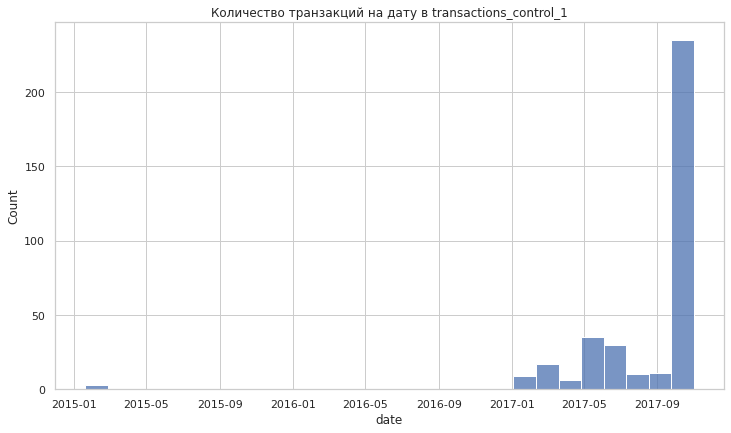

In [46]:
sns.histplot(transactions_control_1.joined_at) \
    .set(title='Количество транзакций на дату в transactions_control_1', xlabel='date');

In [47]:
# какие-то сомнительные даты в transactions_control_1
date_error = transactions_control_1[transactions_control_1.joined_at < pd.to_datetime('2017-01-11')]
date_error

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26,0,refund_VP,other_type
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637,0,refung_AP,other_type
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143,0,refund_WP,other_type


Значение записей с ошибками имеют значения переменной country как Russian Federation.  
Проверим на ошибку данных в записях отфильтровав по country

In [48]:
transactions_control_1[transactions_control_1.country == 'Russian Federation']

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26,0,refund_VP,other_type
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637,0,refung_AP,other_type
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143,0,refund_WP,other_type


Можно сделать предположение что в стране Russian Federation все данные даты пишутся с ошибкой, однако нельзя судить по записям одного пользователя. Также причины добавления этих данных могут быть иными.  
Удалим эти строки.

In [49]:
# удалим эти строки
transactions_control_1.drop(index=date_error.index.tolist(), inplace=True)

In [50]:
# диапазон дат joined_at для transactions_control_1
display(transactions_control_1.joined_at.min().strftime('%Y-%m-%d'),
transactions_control_1.joined_at.max().strftime('%Y-%m-%d'))

'2017-01-11'

'2017-10-31'

Данные о первых и последних регистраиях и покупках у всех трех групп одинаковые, за исключением трех записей из Russian Federation.  
Сообщим об ошибке.

### Вывод:
- дубликаты в transactions_test (7 bp 273), transactions_control_1 (21 из 377), transactions_control_2 (5 из 328)
- много пропущеных данных в transactions_control_1 (из 1007)
- данные о первых и последних регистраиях и покупках у всех трех групп одинаковые, за исключением трех записей из Russian Federation. 
- типы данных скорректированы

Сообщаем об ошибках в данных.  
Предполагаем что исправление ошибок в данных не значительны для эксперимента, приступаем к проведению A/A теста.


2. A/A тест, проверка системы сплитирования
 - проверка на честное деление пользователей по признакам, классическими статистическими методами
 - проверка бизнес метрик бутстрапом (без возвращения) установим  альфу, 90% значений из ориг выборки

3. A/B тест, проверка изменений в ключевых метриках

<a id="2"></a>
## A/A тест,  проверка системы сплитирования
[в оглавление](#0) 

Нулевая гипотеза(H0) A/A теста предполагает что группы по признакам пользователей разделены честно, аданные всех переменных контрольных групп не имеют стат значимых различий.

In [51]:
#объединим таблицы users
users_control_1['group'] = 'control_1'
users_control_2['group'] = 'control_2'
users = pd.concat([users_control_1, users_control_2])

### Проверим пользователей на честное деление по признакам

### Смотрим age

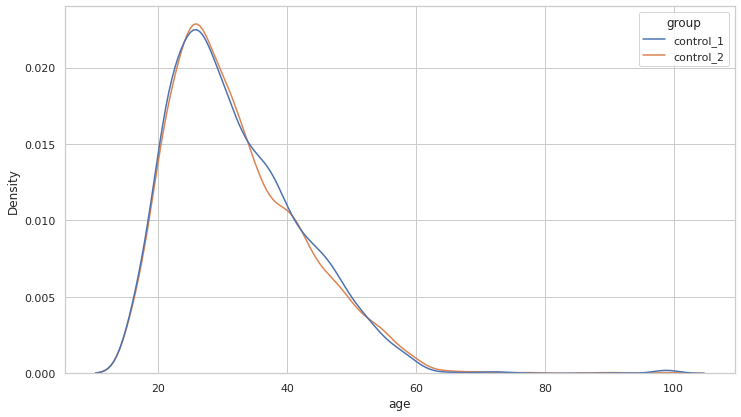

In [52]:
sns.kdeplot(data=users, x='age', hue='group');

Проверим распределения на нормальность

In [53]:
# Normaltest
pg.normality(data=users, dv='age', group='group', method='normaltest')

,W,pval,normal
control_1,915.044035,1.998538e-199,False
control_2,628.103559,4.064857e-137,False


Так как распределения не нормальные для сравнения используем ранговый тест Манна Уитни

In [54]:
# тест Mann Whitney
pg.mwu(users_control_1.age, users_control_2.age, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,9283252.5,two-sided,0.791929,-0.003282,0.501641


H0 pvalue>0.05

### Смотрим attraction_coeff

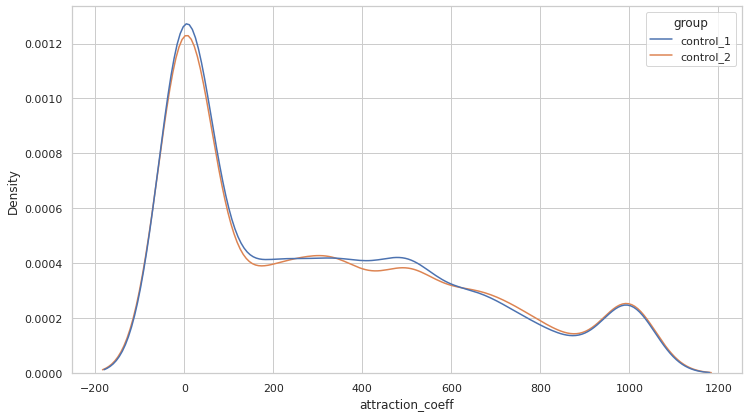

In [55]:
sns.kdeplot(data=users, x='attraction_coeff', hue='group');

Проверим распределения на нормальность

In [56]:
# Normaltest
pg.normality(data=users, dv='attraction_coeff', group='group', method='normaltest')

,W,pval,normal
control_1,491.135681,2.245132e-107,False
control_2,551.367622,1.870863e-120,False


Так как распределения не нормальные для сравнения используем ранговый тест Манна Уитни

In [57]:
# тест Mann Whitney
pg.mwu(users_control_1.attraction_coeff, users_control_2.attraction_coeff, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,9207595.0,two-sided,0.687601,0.004894,0.497553


H0 pvalue>0.05

### Смотрим coins

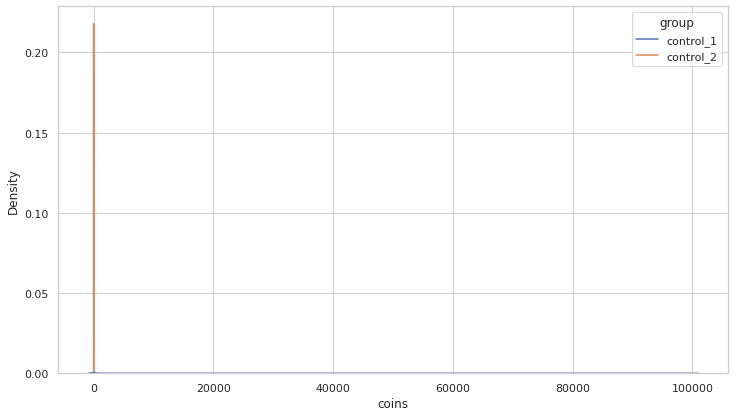

In [58]:
sns.kdeplot(data=users, x='coins', hue='group');

Проверим распределения на нормальность

In [59]:
# Normaltest
pg.normality(data=users, dv='coins', group='group', method='normaltest')

,W,pval,normal
control_1,15108.258841,0.0,False
control_2,13097.914460,0.0,False


Так как распределения не нормальные для сравнения используем ранговый тест Манна Уитни

In [60]:
# тест Mann Whitney
pg.mwu(users_control_1.coins, users_control_2.coins, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,9248835.5,two-sided,0.863343,0.000437,0.499781


H0 pvalue>0.05

### Смотрим country
Мы знаем что среди групп есть страны которые не входят во все группы.  
Мы можем сравнить распределения только тех стран, которые находятся во всех группах.

In [61]:
# страны из каждой группы
tc1 = transactions_control_1.country.unique()
tc2 = transactions_control_2.country.unique()
tt = transactions_test.country.unique()

In [62]:
# найдём общие страны
overall = list(set(tc1).intersection(tc2, tt))
overall

['France',
 'United Arab Emirates',
 'Canada',
 'United Kingdom (Great Britain)',
 'Israel',
 'Germany',
 'Belgium',
 'Argentina',
 'Chile',
 'Italy',
 'United States of America',
 'Spain',
 'Australia',
 'Turkey',
 'Switzerland']

In [63]:
# страны, которые есть только в transactions_control_1
country_1 = list(set(tc1).difference(tc2))
country_1

['India']

In [64]:
# страны, которые есть только в transactions_control_2
country_2 = list(set(tc2).difference(tc1))
country_2

['Lithuania', 'Austria', 'Ukraine']

Так как мы можем сравнить группы только по странам, которые входят в обе группы, мы создадим переменную country_corr со странами где страны не входящие в обе группы обозначим под именем 'Other'

In [65]:
users['country_corr'] = users.country.apply(lambda x: x if x in overall else 'Other')

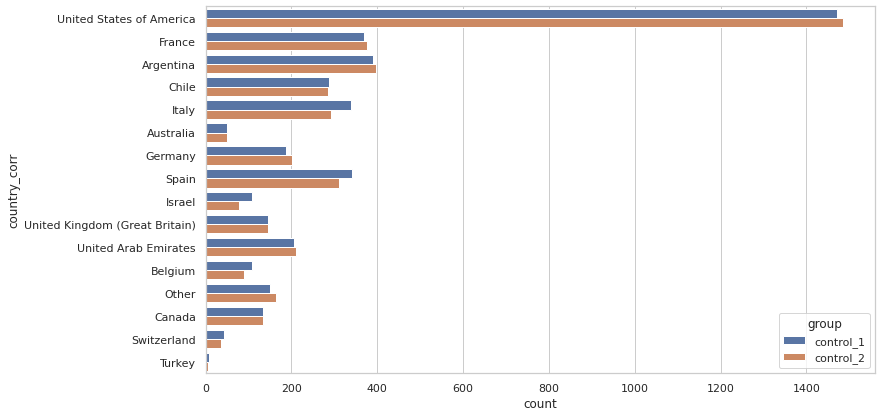

In [66]:
sns.countplot(data=users, y='country_corr', hue='group');

Посмотрим на распределение стран между группами

In [67]:
# таблица сопряжённости
country_table = pd.crosstab(users.country_corr, users.group).reset_index()
country_table.columns = ['country_corr', 'control_1', 'control_2']
country_table

,country_corr,control_1,control_2
0,Argentina,389,397
1,Australia,50,51
2,Belgium,108,90
3,Canada,134,134
4,Chile,287,286
5,France,370,376
6,Germany,188,202
7,Israel,109,78
8,Italy,338,293
9,Other,151,164


In [68]:
# сравниваем через Chi2
results = pg.chi2_independence(users, x='country_corr', y='group')
results[2]

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,13.508323,15.0,0.563097,0.039623,0.617612
1,cressie-read,0.666667,13.516977,15.0,0.562432,0.039636,0.617972
2,log-likelihood,0.000000,13.544102,15.0,0.560348,0.039676,0.619097
3,freeman-tukey,-0.500000,13.573151,15.0,0.558117,0.039718,0.620301
4,mod-log-likelihood,-1.000000,13.609793,15.0,0.555305,0.039772,0.621816
5,neyman,-2.000000,13.706454,15.0,0.547899,0.039913,0.625798


H0 pvalue>0.05

### Смотрим visit_days_count

Для сравнения принака visit_days нам необходимо разложить его на две составляющие:
- visit_days_list значений дня визита с момента регистрации
- visit_days_count количество дней в которые был визит

In [69]:
users['visit_days_list'] = users.visit_days.apply(lambda x: [] if type(x) == float else x.split(','))
users['visit_days_count'] = users.visit_days_list.apply(lambda x: len(x))
users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,country_corr,visit_days_list,visit_days_count
0,892319115,25,435,0,United States of America,"1,2,3,4,5,6",0,22,32,982,0,0,0,control_1,United States of America,"[1, 2, 3, 4, 5, 6]",6
1,891248523,29,500,0,United States of America,"1,2",1,26,32,12,0,0,0,control_1,United States of America,"[1, 2]",2
2,891670932,33,800,0,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,0,0,0,control_1,France,"[1, 2, 3, 5, 6, 8, 9, 11, 13, 16]",10
3,891060786,26,0,0,Argentina,"1,2,3,4,5",1,23,29,0,0,0,0,control_1,Argentina,"[1, 2, 3, 4, 5]",5
4,892006554,35,294,0,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,0,0,0,control_1,United States of America,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 15, 16, 17, 19]",14


Рассмотрим visit_days_count

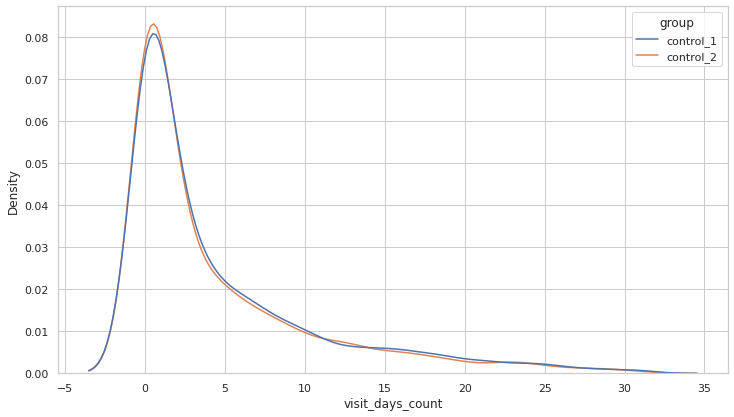

In [70]:
sns.kdeplot(data=users, x='visit_days_count', hue='group');

Проверим распределения на нормальность

In [71]:
# проверим нормальность распределения Normaltest
pg.normality(data=users, dv='visit_days_count', group='group', method='normaltest')

,W,pval,normal
control_1,1434.426771,0.0,False
control_2,1468.996018,0.0,False


Так как распределения не нормальные для сравнения используем ранговый тест Манна Уитни

In [72]:
# тест Mann Whitney
control_1 = users[users.group == 'control_1']
control_2 = users[users.group == 'control_2']
pg.mwu(control_1.visit_days_count, control_2.visit_days_count, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,9448306.0,two-sided,0.083984,-0.021121,0.51056


H0 pvalue>0.05

### Смотрим visit_days_list
Будем сравнивать распределения по средним значениям посещений пользователя на определённый день

In [73]:
# собирает список из значений списка списков
# если список в списке пустой - добавляет 0
def date_hist(data):
    result = []
    for list_ in data:
        if len(list_) == 0:
            result.append(0)
        else:
            for i in list_:
                result.append(int(i))
    return result

# возращает список списков, всех дней посещений всех пользователей по группам
def get_graph_dates(data):
    groups = data.group.unique().tolist()
    kde = []
    result = {}
    result
    for group in groups:
        data_group = data[data.group == group]
        list_data = date_hist(data_group.visit_days_list)
        kde.append(list_data)
        result[group] = list_data
    sns.kdeplot(data=kde).set(title='Среднее значение посещений пользователя на определённый день после регистрации')
    
    return result

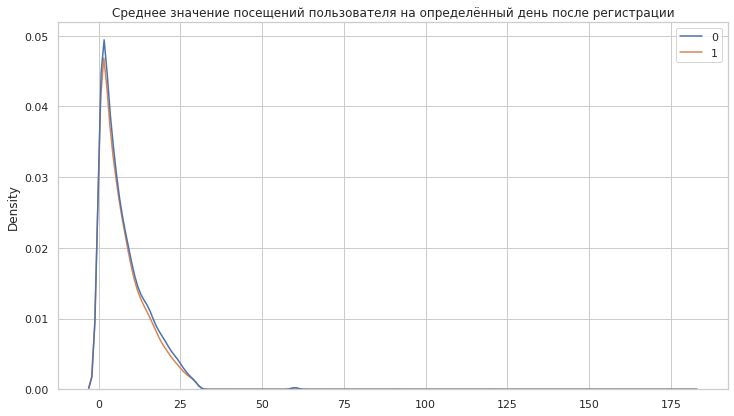

In [74]:
dates = get_graph_dates(users)

Проверим распределения на нормальность

In [75]:
# нормальность распределения
scipy.stats.normaltest(dates['control_1'])

NormaltestResult(statistic=13710.540698184379, pvalue=0.0)

H1 pvalue<0.05

Так как распределения не нормальные для сравнения используем ранговый тест Манна Уитни

In [76]:
control_1 = dates['control_1']
control_2 = dates['control_2']

In [77]:
# не нормальные распределения, Mann Whitney
scipy.stats.mannwhitneyu(control_1, control_2, alternative='two-sided')

MannwhitneyuResult(statistic=221281177.0, pvalue=0.011604694473615944)

H1 pvalue<0.05

### Смотрим gender

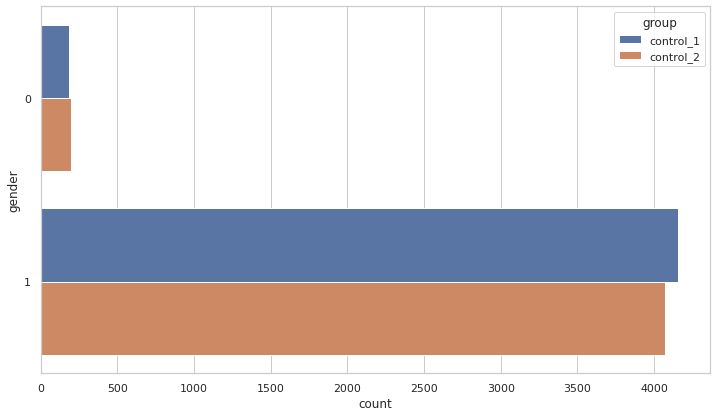

In [78]:
sns.countplot(data=users, y='gender', hue='group');

In [79]:
gender_table = pd.crosstab(users.gender, users.group).reset_index().drop(columns='gender').T.reset_index()
gender_table.columns = ['group','woman', 'man']
gender_table

,group,woman,man
0,control_1,182,4158
1,control_2,195,4069


In [80]:
expected, observed, stats = pg.chi2_independence(users, x='gender', y='group')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.651989,1.0,0.419402,0.008705,0.127382
1,cressie-read,0.666667,0.651977,1.0,0.419407,0.008705,0.127380
2,log-likelihood,0.000000,0.652012,1.0,0.419394,0.008705,0.127385
3,freeman-tukey,-0.500000,0.652088,1.0,0.419367,0.008706,0.127394
4,mod-log-likelihood,-1.000000,0.652207,1.0,0.419325,0.008706,0.127408
5,neyman,-2.000000,0.652574,1.0,0.419194,0.008709,0.127453


H0 pvalue>0.05

## Смотрим age_filter_start

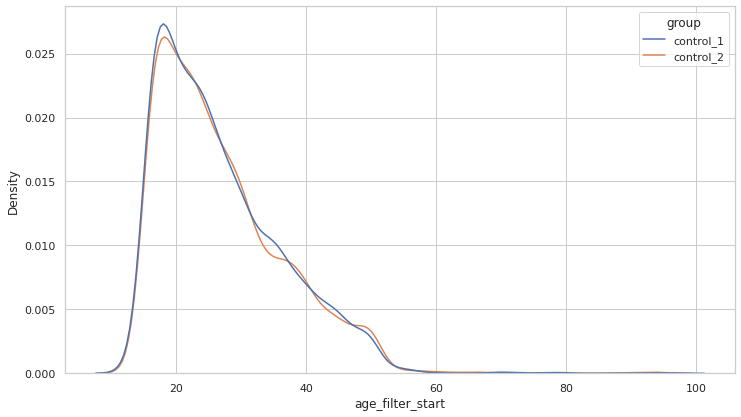

In [81]:
sns.kdeplot(data=users, x='age_filter_start', hue='group');

Проверим распределения на нормальность

In [82]:
# проверим нормальность распределения Normaltest
pg.normality(data=users, dv='age_filter_start', group='group', method='normaltest')

,W,pval,normal
control_1,769.022657,1.020591e-167,False
control_2,921.935386,6.371982e-201,False


Так как распределения не нормальные для сравнения используем ранговый тест Манна Уитни

In [83]:
# тест Mann Whitney
pg.mwu(users_control_1.age_filter_start, users_control_2.age_filter_start, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,9171262.5,two-sided,0.478098,0.008821,0.49559


H0 pvalue>0.05

### Смотрим age_filter_end

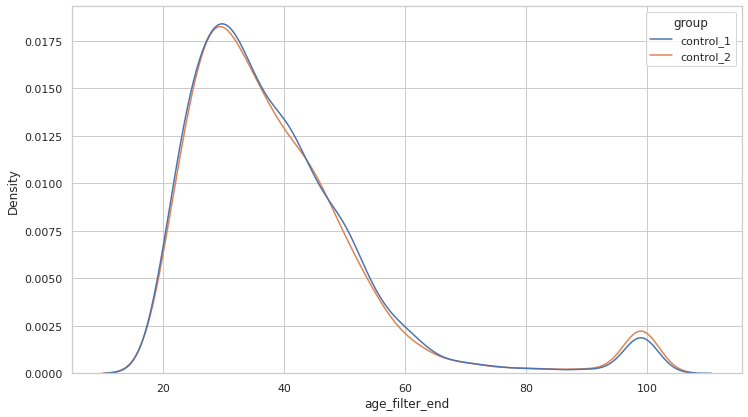

In [84]:
sns.kdeplot(data=users, x='age_filter_end', hue='group');

Проверим распределения на нормальность

In [85]:
# проверим нормальность распределения Normaltest
pg.normality(data=users, dv='age_filter_end', group='group', method='normaltest')

,W,pval,normal
control_1,1733.768368,0.0,False
control_2,1743.599233,0.0,False


Так как распределения не нормальные для сравнения используем ранговый тест Манна Уитни

In [86]:
# тест Mann Whitney
pg.mwu(users_control_1.age_filter_end, users_control_2.age_filter_end, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,9218374.5,two-sided,0.764434,0.003729,0.498135


H0 pvalue>0.05

### Смотрим views_count

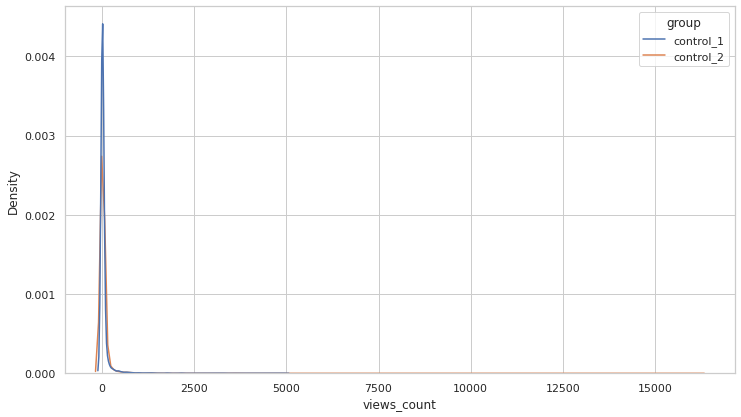

In [87]:
sns.kdeplot(data=users, x='views_count', hue='group');

Проверим распределения на нормальность

In [88]:
# проверим нормальность распределения Normaltest
pg.normality(data=users, dv='views_count', group='group', method='normaltest')

,W,pval,normal
control_1,8066.097566,0.0,False
control_2,11774.894047,0.0,False


Так как распределения не нормальные для сравнения используем ранговый тест Манна Уитни

In [89]:
# тест Mann Whitney
pg.mwu(users_control_1.views_count, users_control_2.views_count, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,9347993.0,two-sided,0.406726,-0.010279,0.50514


H0 pvalue>0.05

### Смотрим was_premium

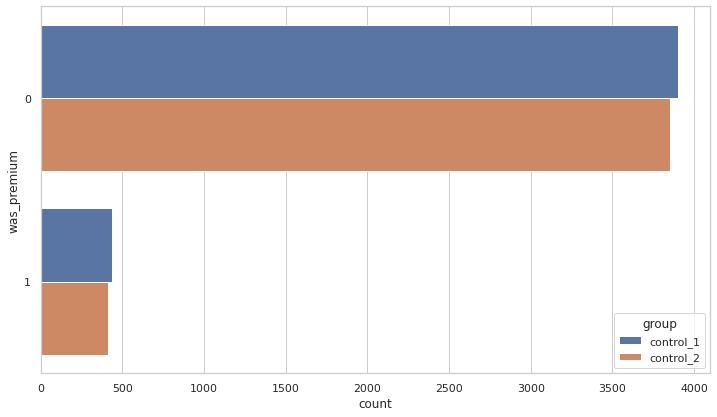

In [90]:
sns.countplot(data=users, y='was_premium', hue='group');

In [91]:
was_table = pd.crosstab(users.was_premium, users.group).reset_index().drop(columns='was_premium').T.reset_index()
was_table.columns = ['group','no_was_premium', 'was_premium']
was_table

,group,no_was_premium,was_premium
0,control_1,3904,436
1,control_2,3853,411


In [92]:
expected, observed, stats = pg.chi2_independence(users, x='was_premium', y='group')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.357348,1.0,0.549983,0.006445,0.091838
1,cressie-read,0.666667,0.357365,1.0,0.549974,0.006445,0.091840
2,log-likelihood,0.000000,0.357405,1.0,0.549951,0.006445,0.091845
3,freeman-tukey,-0.500000,0.357441,1.0,0.549931,0.006445,0.091850
4,mod-log-likelihood,-1.000000,0.357482,1.0,0.549908,0.006446,0.091854
5,neyman,-2.000000,0.357580,1.0,0.549853,0.006447,0.091866


H0 pvalue>0.05

### Смотрим is_premium

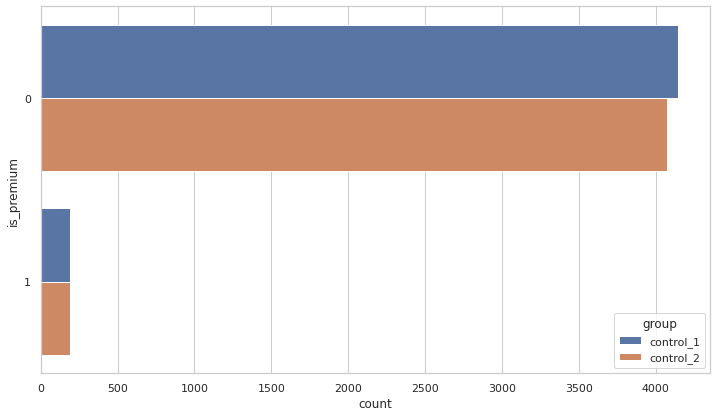

In [93]:
sns.countplot(data=users, y='is_premium', hue='group');

In [94]:
is_table = pd.crosstab(users.is_premium, users.group).reset_index().drop(columns='is_premium').T.reset_index()
is_table.columns = ['group','no_is_premium', 'is_premium']
is_table

,group,no_is_premium,is_premium
0,control_1,4148,192
1,control_2,4073,191


In [95]:
result = pg.chi2_independence(users, x='was_premium', y='group')
result[2]

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.357348,1.0,0.549983,0.006445,0.091838
1,cressie-read,0.666667,0.357365,1.0,0.549974,0.006445,0.091840
2,log-likelihood,0.000000,0.357405,1.0,0.549951,0.006445,0.091845
3,freeman-tukey,-0.500000,0.357441,1.0,0.549931,0.006445,0.091850
4,mod-log-likelihood,-1.000000,0.357482,1.0,0.549908,0.006446,0.091854
5,neyman,-2.000000,0.357580,1.0,0.549853,0.006447,0.091866


H0 pvalue>0.05

### Посмотрим на показатели пользовательской активности между группами

In [96]:
# соберём данные
transact = pd.concat([transactions_control_1, transactions_control_2])
transact = transact.merge(users[['uid', 'group', 'country_corr']], on='uid')

# уберём страны не пересекающиеся в группах
transact.drop(columns='country', inplace=True)

# добавим значений
transact['joined_at'] = transact.joined_at.astype('datetime64[ns]')
transact['joined'] = transact['joined_at'].dt.strftime('%Y-%m')

transact.head()

,uid,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,country_corr,joined
0,891319275,2017-05-11 19:57:00,2017-12-11 21:57:00,12727,147,trial_vip_popup,trial_premium,control_1,France,2017-05
1,891319275,2017-05-11 19:57:00,2017-05-11 20:05:00,728,146,ad_to_photo,coins,control_1,France,2017-05
2,892421826,2017-10-14 12:46:00,2017-10-23 12:54:00,14586,147,trial_vip_popup,trial_premium,control_1,Israel,2017-10
3,891822480,2017-10-26 22:27:00,2017-12-11 20:59:00,1911,19,none,coins,control_1,Italy,2017-10
4,891822480,2017-10-26 22:27:00,2017-01-11 16:50:00,1898,19,none,coins,control_1,Italy,2017-10


### Смотрим country

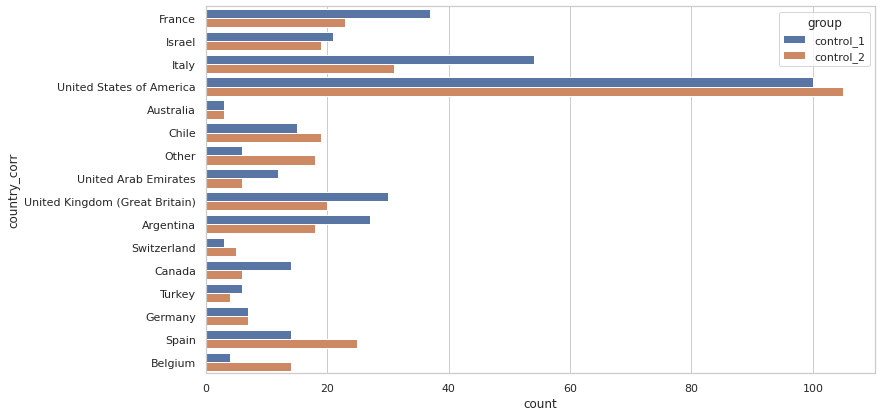

In [97]:
sns.countplot(data=transact, y='country_corr', hue='group');

In [98]:
country = pd.crosstab(transact.country_corr, transact.group).reset_index()
country.columns = ['country_corr','control_1', 'control_2']
country = country.replace([0, 1, 2, 3, 4], np.nan).dropna().set_index('country_corr')
# так как мы не можем сравнивать страны где значения меньше 5
over = country.index.tolist()
country

,control_1,control_2
country_corr,,
Argentina,27.0,18.0
Canada,14.0,6.0
Chile,15.0,19.0
France,37.0,23.0
Germany,7.0,7.0
Israel,21.0,19.0
Italy,54.0,31.0
Other,6.0,18.0
Spain,14.0,25.0


In [99]:
result = pg.chi2_independence(transact[transact.country_corr.isin(over)], x='country_corr', y='group')
result[2]

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,25.864595,11.0,0.006798,0.201980,0.956273
1,cressie-read,0.666667,25.950442,11.0,0.006601,0.202315,0.956967
2,log-likelihood,0.000000,26.347010,11.0,0.005761,0.203855,0.960048
3,freeman-tukey,-0.500000,26.858997,11.0,0.004826,0.205826,0.963732
4,mod-log-likelihood,-1.000000,27.579133,11.0,0.003754,0.208567,0.968395
5,neyman,-2.000000,29.776459,11.0,0.001718,0.216716,0.979458


H1 pvalue<0.05

### Смотрим joined_at

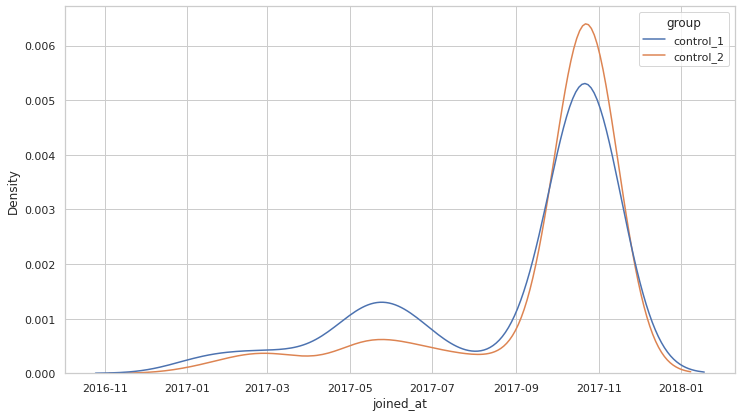

In [100]:
sns.kdeplot(data=transact, x='joined_at', hue='group');

In [101]:
joined = pd.crosstab(transact.joined, transact.group).reset_index()
joined.columns = ['joined','control_1', 'control_2']
joined = joined.replace([0, 1, 2, 3, 4], np.nan).dropna().set_index('joined')
# так как мы не можем сравнивать страны где значения меньше 5
over = joined.index.tolist()
joined#.head()

,control_1,control_2
joined,,
2017-02,8.0,8.0
2017-03,9.0,8.0
2017-05,35.0,16.0
2017-06,30.0,12.0
2017-07,6.0,8.0
2017-09,11.0,6.0
2017-10,235.0,253.0


In [102]:
result = pg.chi2_independence(transact[transact.joined.isin(over)], x='joined', y='group')
result[2]

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,16.472568,6.0,0.011430,0.159809,0.880228
1,cressie-read,0.666667,16.578386,6.0,0.010964,0.160321,0.882592
2,log-likelihood,0.000000,16.903587,6.0,0.009644,0.161886,0.889612
3,freeman-tukey,-0.500000,17.254820,6.0,0.008391,0.163559,0.896789
4,mod-log-likelihood,-1.000000,17.707617,6.0,0.007006,0.165691,0.905446
5,neyman,-2.000000,18.963718,6.0,0.004225,0.171468,0.926246


H1 pvalue<0.05

### Смотрим from_page

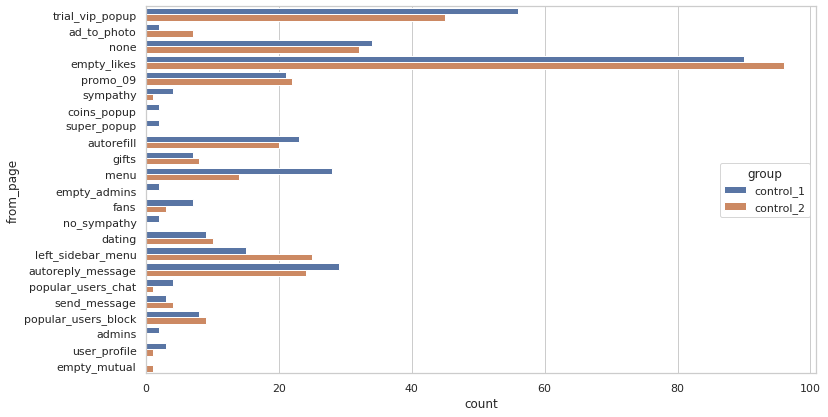

In [103]:
sns.countplot(data=transact, y='from_page', hue='group');

In [104]:
from_page = pd.crosstab(transact.group, transact.from_page).T
from_page = from_page.replace([0, 1, 2, 3, 4], np.nan).dropna()
over = from_page.index.tolist()
from_page

group,control_1,control_2
from_page,,
autorefill,23.0,20.0
autoreply_message,29.0,24.0
dating,9.0,10.0
empty_likes,90.0,96.0
gifts,7.0,8.0
left_sidebar_menu,15.0,25.0
menu,28.0,14.0
none,34.0,32.0
popular_users_block,8.0,9.0


In [105]:
result = pg.chi2_independence(transact[transact.from_page.isin(over)], x='from_page', y='group')
result[2]

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,9.146487,10.0,0.518260,0.120973,0.497503
1,cressie-read,0.666667,9.172558,10.0,0.515809,0.121145,0.498899
2,log-likelihood,0.000000,9.261811,10.0,0.507450,0.121733,0.503669
3,freeman-tukey,-0.500000,9.362626,10.0,0.498069,0.122394,0.509037
4,mod-log-likelihood,-1.000000,9.494156,10.0,0.485934,0.123250,0.516005
5,neyman,-2.000000,9.857248,10.0,0.453105,0.125585,0.535029


H1 pvalue<0.05

### Проверим бизнес метрики 
Ключевые: AvgCheck, Revenue, CR, product_type  
Чувствительные: ARPU, ARPPU

### Смотрим product_type

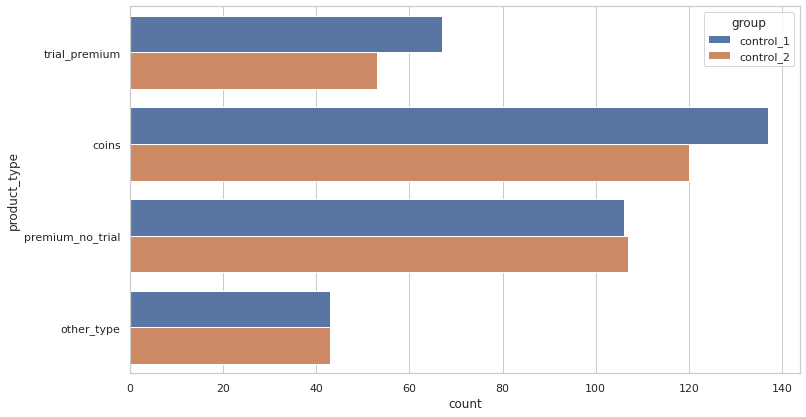

In [106]:
sns.countplot(data=transact, y='product_type', hue='group');

In [107]:
from_page = pd.crosstab(transact.group, transact.product_type).T
from_page

group,control_1,control_2
product_type,,
coins,137,120
other_type,43,43
premium_no_trial,106,107
trial_premium,67,53


In [108]:
result = pg.chi2_independence(transact, x='product_type', y='group')
result[2]

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,1.434005,3.0,0.697583,0.046058,0.147867
1,cressie-read,0.666667,1.434341,3.0,0.697505,0.046063,0.147893
2,log-likelihood,0.000000,1.435291,3.0,0.697284,0.046078,0.147965
3,freeman-tukey,-0.500000,1.436247,3.0,0.697061,0.046094,0.148038
4,mod-log-likelihood,-1.000000,1.437413,3.0,0.696789,0.046112,0.148127
5,neyman,-2.000000,1.440380,3.0,0.696097,0.046160,0.148353


H0 pvalue>0.05

### Смотрим AvgCheck

In [109]:
# Проведём A/A бутстрап тест (t-test) 
def simulation(control, test, simulations=5000, size=100):
    result = []
    for i in tqdm(range(simulations)):
        s_1 = random.sample(list(control), size) # без возвращения
        s_2 = random.sample(list(test), size) # без возвращения
        # equal_var=False (поправка Уэлша, в группах могут быть разные дисперсии)
        result.append(scipy.stats.ttest_ind(s_1, s_2, equal_var=False)[1])
    return [result, simulations]


def graph(result, alfa=0.05):  
    # проверка результат ложноположительных тестов не превышает alfa
    fpr = sum(np.array(result[0]) < alfa) / result[1]  
    # график
    color='cornflowerblue'
    if fpr >= alfa:
        color='tomato'       
    plt.hist(result[0], color=color, bins=50)
    plt.xlabel('pvalue')
    plt.ylabel('frequency')
    text = 'histogram of ttest A/A simulations '
    plt.title(text)
    plt.show()
    print(f'α={alfa}, FPR={fpr}')

In [110]:
# сравним средний чек
avg_check = transact[transact.revenue > 0].groupby('uid').agg({'revenue': 'mean', 'group': 'first'}).reset_index()
avg_check.head()

,uid,revenue,group
0,891068079,5148.0,control_2
1,891075072,2327.0,control_2
2,891077727,6292.0,control_2
3,891080040,1891.5,control_2
4,891092322,3315.0,control_1


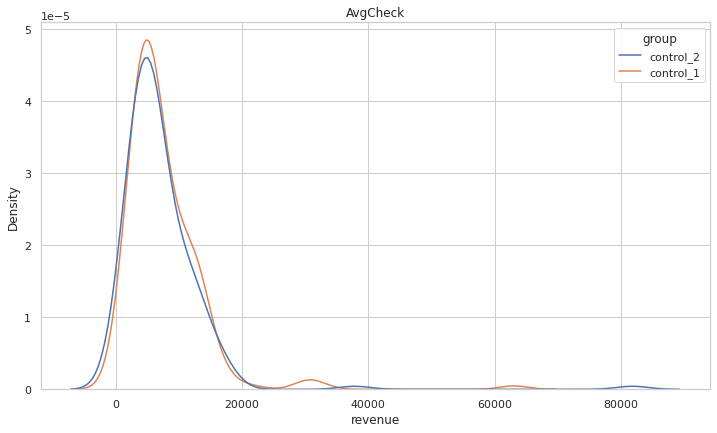

In [111]:
sns.kdeplot(data=avg_check, x='revenue', hue='group').set(title='AvgCheck');

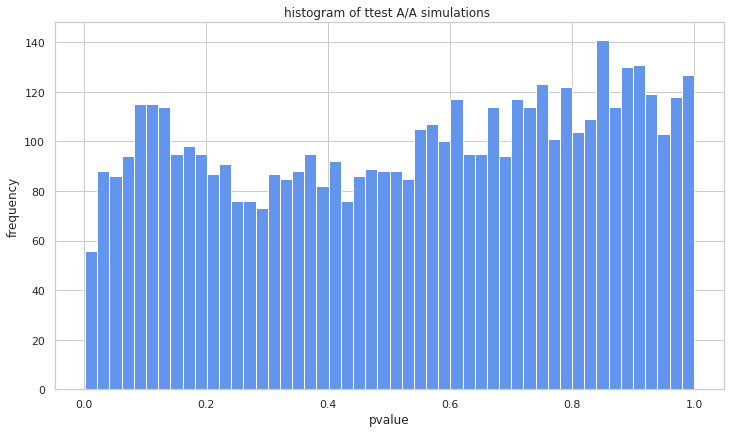

α=0.05, FPR=0.0364


In [112]:
# средний чек
result = simulation(avg_check[avg_check.group == 'control_1'].revenue, \
                    avg_check[avg_check.group == 'control_2'].revenue)
graph(result)

H0 FPR<α

### Смотрим total_revenue и revenue в users

In [113]:
# Посчитаем revenue для каждого пользователя
transact_revenue = transact.groupby('uid').agg({'revenue': 'sum'}).reset_index()

# добавим в таблицу users
revenue = users.merge(transact_revenue, on='uid', how='left')
revenue['revenue'] = revenue.revenue.fillna(0).astype(int)

# обозначим сконвертировавшихся uid
revenue['cr'] = revenue.revenue.apply(lambda x: 1 if x>0 else 0)
revenue.head(1)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,country_corr,visit_days_list,visit_days_count,revenue,cr
0,892319115,25,435,0,United States of America,"1,2,3,4,5,6",0,22,32,982,0,0,0,control_1,United States of America,"[1, 2, 3, 4, 5, 6]",6,0,0


In [114]:
# пользователи у которых регистрация позже оплаты
print('Пользователей у которых регистрация позже оплаты', len(transact[transact.paid_at < transact.joined_at]))

Пользователей у которых регистрация позже оплаты 115


In [115]:
# сравним с total_revenue
revenue.revenue.sum() == revenue.total_revenue.sum()

False

Данные между revenue из таблиц users и total_revenue таблиц transactions расходятся.  
Возможно система допускает оплату до регистрации.  
Возможно часть данных о транзакциях была внесена в total_revenue до эксперимента.  
Это может служить причиной расхождения данных между revenue и total_revenue.  

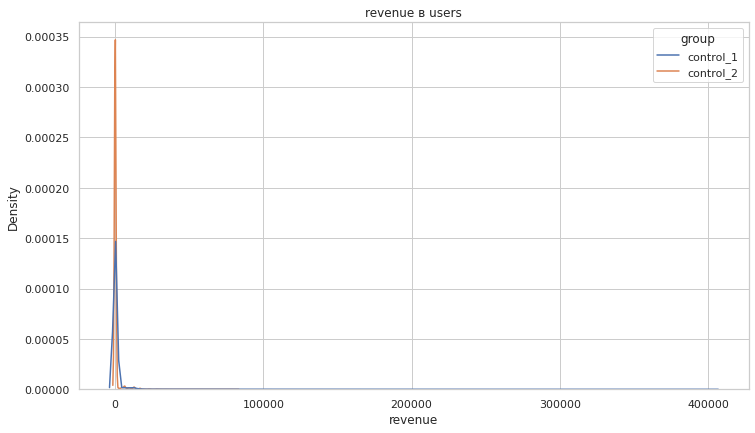

In [116]:
sns.kdeplot(data=revenue, x='revenue', hue='group').set(title='revenue в users');

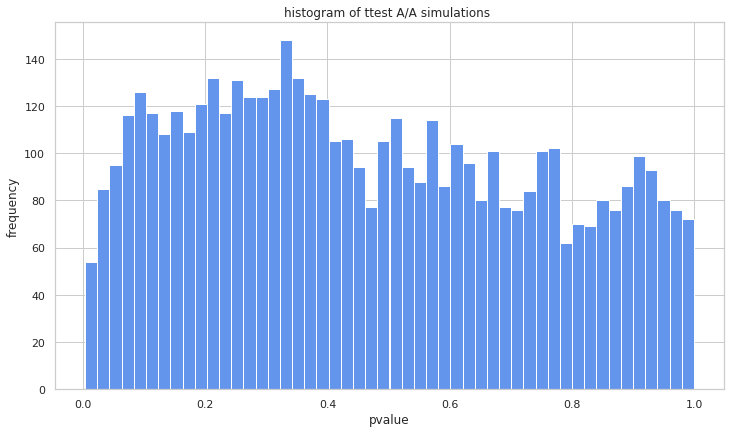

α=0.05, FPR=0.0346


In [117]:
# revenue в users
result = simulation(revenue[revenue.group == 'control_1'].revenue, \
                    revenue[revenue.group == 'control_2'].revenue)
graph(result)

H0 FPR<α

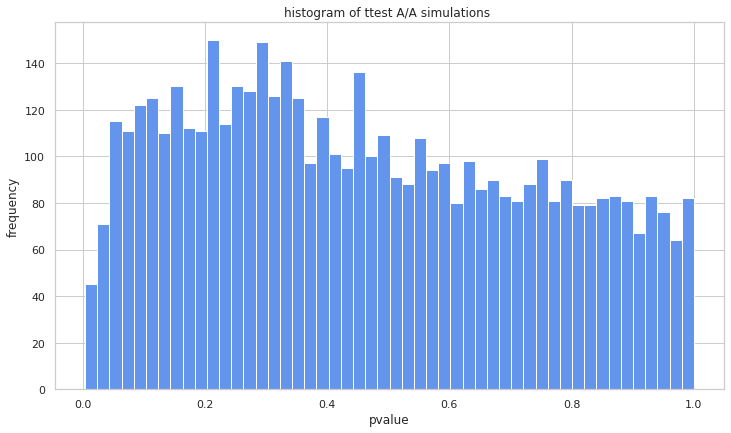

α=0.05, FPR=0.0308


In [118]:
# total_revenue в users
result = simulation(revenue[revenue.group == 'control_1'].total_revenue, \
                    revenue[revenue.group == 'control_2'].total_revenue)
graph(result)

H0 FPR<α

### Смотрим ARPU, ARPPU, CR а также revenue в transactions

Для расчёта ARPU будем пользоваться данными из колонки revenue

In [119]:
# считаем по группам revenue
result = revenue.groupby('group').agg({'revenue': 'sum'}).reset_index()

# считаем по группам arpu
arpu = revenue.groupby('group').agg({'uid': 'count', 'revenue': 'sum'}).reset_index()
arpu['ARPU'] = round(arpu.revenue / arpu.uid)
arpu = arpu[['group', 'ARPU']]
d1 = arpu[arpu.group == 'control_1'].ARPU.values[0] / arpu[arpu.group == 'control_2'].ARPU.values[0]
print('в группе control_2 ARPU меньше на ', round((d1-1)*100, 2), '%')

# считаем по группам arppu
arppu = revenue[revenue.revenue > 0].groupby('group').agg({'uid': 'count', 'revenue': 'sum'}).reset_index()
arppu['ARPPU'] = round(arppu.revenue / arppu.uid)
arppu = arppu[['group', 'ARPPU']]
d2 = arppu[arppu.group == 'control_1'].ARPPU.values[0] / arppu[arppu.group == 'control_2'].ARPPU.values[0]
print('в группе control_2 ARPPU меньше на ', round((d2-1)*100, 2), '%')

# считаем по группам cr
cr = revenue.groupby('group').agg({'uid': 'count', 'cr': 'sum'}).reset_index()
cr['CR'] = round(cr.cr / cr.uid, 4)
cr = cr[['group', 'CR']]
d3 = cr[cr.group == 'control_1'].CR.values[0] / cr[cr.group == 'control_2'].CR.values[0]
print('в группе control_2 CR меньше на ', round((d3-1)*100, 2), '%')

result.merge(arpu, on='group').merge(arppu, on='group').merge(cr, on='group')

в группе control_2 ARPU меньше на  28.64 %
в группе control_2 ARPPU меньше на  27.32 %
в группе control_2 CR меньше на  0.68 %


,group,revenue,ARPU,ARPPU,CR
0,control_1,2493998,575.0,12990.0,0.0442
1,control_2,1907997,447.0,10203.0,0.0439


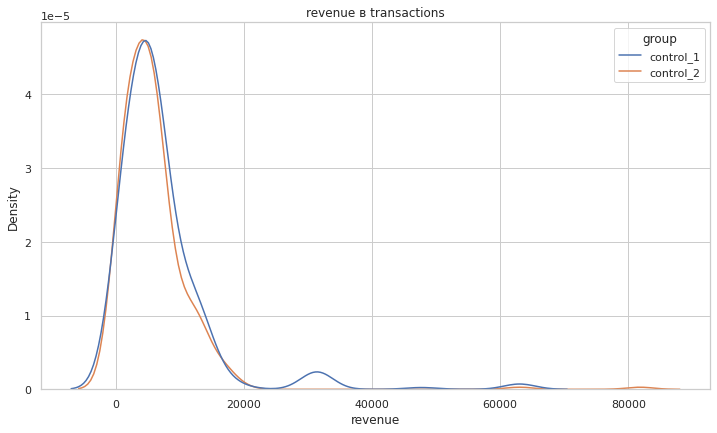

In [120]:
sns.kdeplot(data=transact, x='revenue', hue='group').set(title='revenue в transactions');

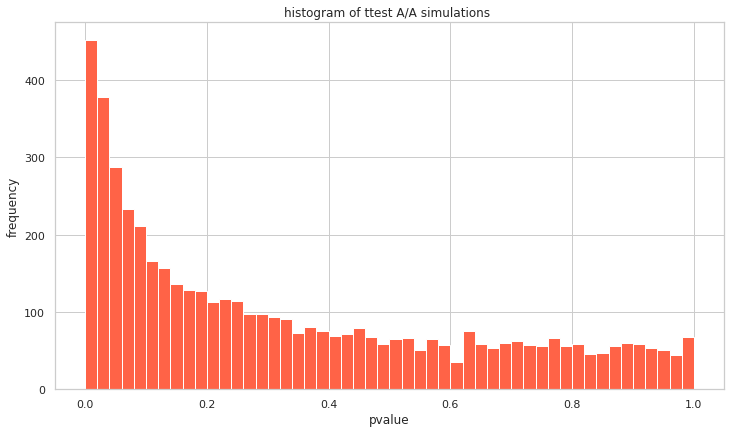

α=0.05, FPR=0.1978


In [121]:
# revenue в transactions
result = simulation(transact[transact.group == 'control_1'].revenue, \
                    transact[transact.group == 'control_2'].revenue)
graph(result)

### Результаты:


#### Проверка групп на честное деление по признакам

users.age - H0(Mann Whithey U test)  
users.attraction_coeff - H0(Mann Whithey U test)  
users.coins - H0(Mann Whithey U test)  
users.age_filter_start - H0(Mann Whithey U test)    
users.age_filter_end - H0(Mann Whithey U test)  
users.views_count - H0(Mann Whithey U test)  

users.gender - H0(Chi2)  
users.was_premium - H0(Chi2)  
users.is_premium - H0(Chi2)  
users.country - H0(Chi2), при сравнении страны различающиеся в группах переопределили под именем 'Others' 


users.visit_days_count (так как невозможно сравнить статистическими методами - разложили на 2 признака):  
 visit_days_list (значений дня визита с момента регистрации) - H0(Mann Whithey U test)  
 visit_days_count (количество дней в которые был визит) - H1(Mann Whithey U test)

transactions.country - H1(Chi2)  
transactions.joined_at (сгруппированы по месяцам) - H1(Chi2)
transactions.from_page - H1(Chi2)  


#### Проверка групп на бизнес метриках

transactions.product_type = H0(Chi2)  

так как значения Revenue расходятся в таблицах users и transactions проверили оба:
transactions.AvgCheck H0(bootstrap)  

users.revenue H0(bootstrap)  
users.total_revenue H0(bootstrap) 

CR меньше на 0.68% в группе control_2  
ARPU меньше на 28% в группе control_2  
ARPPU меньше на 27% в группе control_2  

transactions.revenue H1(bootstrap) 

### Вывод:

Проверка на честное деление по признакам прошла успешно, с незначительными отклонениями таблицы transactions колонок country, joined_at, from_page  
Также бизнес метрики показывают отсутствие различий по признакам revenue таблицы users.

Однако таблица transactions показывает статистически значимые различия среднего значения в revenue а также показателях CR, ARPU и ARPPU  Если это допустимо в рамках A/A теста, тогда приступаем к анализу результатов A/B теста.

<a id="3"></a>
## A/B тест, проверка изменений в ключевых метриках
[в оглавление](#0) 

Результаты A/B теста определяют наличие или отсутствие статистически значимых различий тестовой и контрольной группы, в ключевых метриках:  

AvgCheck   
CR1  

product_type:  
CR_trial_premium  
CR_premium_no_trial    

AvgCheck  
CR1  
ARPU  
ARPPU  


Проверим статистичискую значимость в изменениях метрик test и control групп а также измерим различия.

Для начала объединим необходимые для вычислений данные из групп control и таблицы users и transactions.

In [122]:
# выберем необходимые данные из users
users_test['group'] = 'test'
users_control_1['group'] = 'control'
users_control_2['group'] = 'control'
users = pd.concat([users_test, users_control_1, users_control_2])[['uid', 'group']]

In [123]:
# преобразуем данные transactions
transactions_test['group'] = 'test'
transactions_control_1['group'] = 'control'
transactions_control_2['group'] = 'control'
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2])
transactions['trial_premium'] = transactions.product_type.apply(lambda x: 1 if x == 'trial_premium' else 0)
transactions['premium_no_trial'] = transactions.product_type.apply(lambda x: 1 if x == 'premium_no_trial' else 0)
transactions.drop(columns=['group'], inplace=True)
transactions = transactions.merge(users, on='uid', how='outer')
transactions['trial_premium'] = transactions.trial_premium.fillna(0)
transactions['premium_no_trial'] = transactions.premium_no_trial.fillna(0)
transactions['revenue'] = transactions.revenue.fillna(0)
transactions['cr'] = transactions.revenue.apply(lambda x: 1 if x>0 else 0)
transactions = transactions[['uid', 'revenue', 'trial_premium', 'premium_no_trial', 'group', 'cr']]
transactions

,uid,revenue,trial_premium,premium_no_trial,group,cr
0,891345942,12909.0,1.0,0.0,test,1
1,892054251,13923.0,1.0,0.0,test,1
2,892236423,3783.0,0.0,0.0,test,1
3,892236423,3783.0,0.0,0.0,test,1
4,892236423,1261.0,0.0,0.0,test,1
...,...,...,...,...,...,...
13324,891937401,0.0,0.0,0.0,control,0
13325,891692844,0.0,0.0,0.0,control,0
13326,891096429,0.0,0.0,0.0,control,0
13327,891697584,0.0,0.0,0.0,control,0


### Сравним средний чек

In [124]:
# определим размер среднего чека для каждого пользователя
avgcheck = transactions[transactions.revenue > 0].groupby('uid') \
    .agg({'revenue': 'mean', 'group': 'first'}).rename(columns={'revenue': 'avg_check'}).reset_index()
avgcheck.head()

,uid,avg_check,group
0,891068079,5148.0,control
1,891071157,9100.0,test
2,891075072,2327.0,control
3,891077727,6292.0,control
4,891080040,1891.5,control


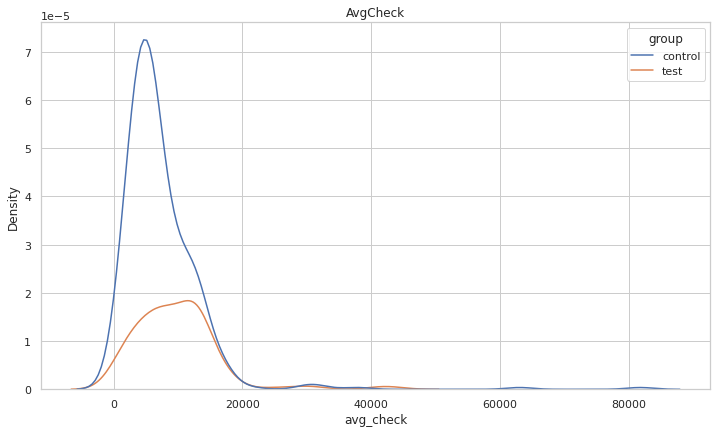

In [125]:
sns.kdeplot(data=avgcheck, x='avg_check', hue='group').set(title='AvgCheck');

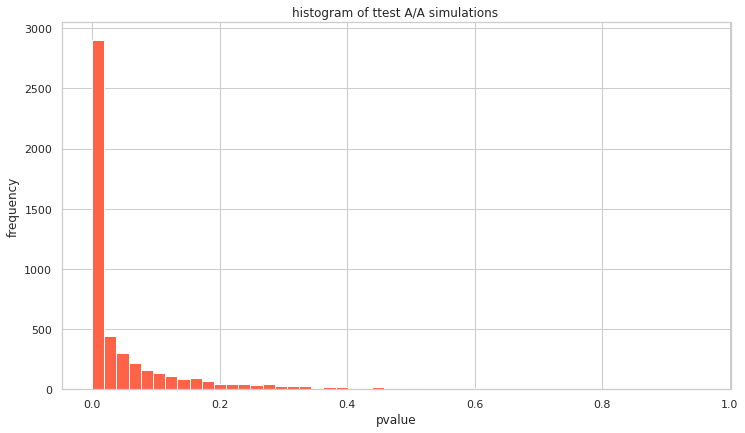

α=0.05, FPR=0.71


In [126]:
# посчитаем стат значимость различий test и control у avg_check
result = simulation(avgcheck[avgcheck.group == 'test'].avg_check, \
                    avgcheck[avgcheck.group == 'control'].avg_check)
graph(result)

H1 FPR>α

In [127]:
# разница в среднем чеке
avg = avgcheck.groupby('group').agg({'avg_check': 'mean'}).reset_index()
avg

,group,avg_check
0,control,7362.380389
1,test,9696.295583


### Сравним CR1(в покупку)

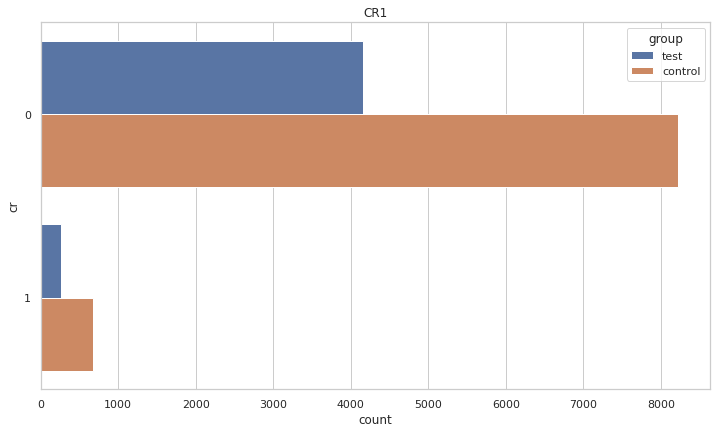

In [128]:
sns.countplot(data=transactions, y='cr', hue='group').set(title='CR1');

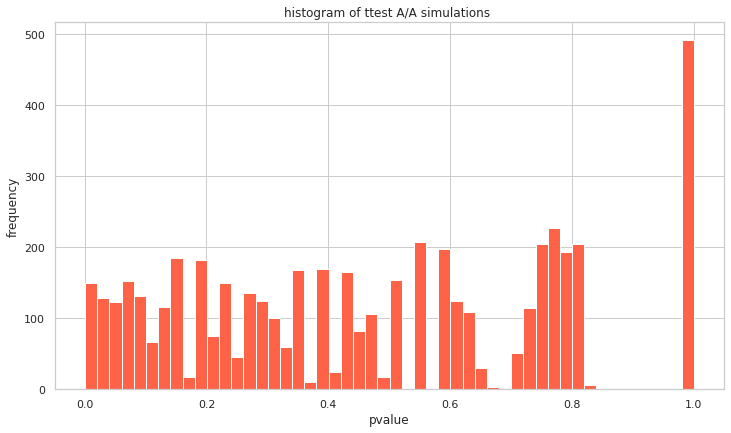

α=0.05, FPR=0.0678


In [129]:
# посчитаем стат значимость различий test и control у total_revenue в users
result = simulation(transactions[transactions.group == 'test'].cr, \
                    transactions[transactions.group == 'control'].cr)
graph(result)

H1 FPR>α

In [130]:
# разница в конверсии
cr = transactions.groupby('group').agg({'uid': 'count', 'cr': 'sum'}).reset_index()
cr['CR1'] = round(cr.cr / cr.uid, 3)
cr = cr[['group', 'CR1']]
cr

,group,CR1
0,control,0.076
1,test,0.060


### Сравним ARPU и ARPPU

In [131]:
# посчитаем ARPU и ARPPU
aru = transactions.groupby('group').agg({'uid': 'count', 'revenue': 'sum', 'cr': 'sum'}).reset_index()
aru['ARPU'] = round(aru.revenue / aru.uid)
aru['ARPPU'] = round(aru.revenue / aru.cr)
aru = aru[['group', 'ARPU', 'ARPPU']]
aru

,group,ARPU,ARPPU
0,control,495.0,6512.0
1,test,527.0,8768.0


### Сравним trial_premium

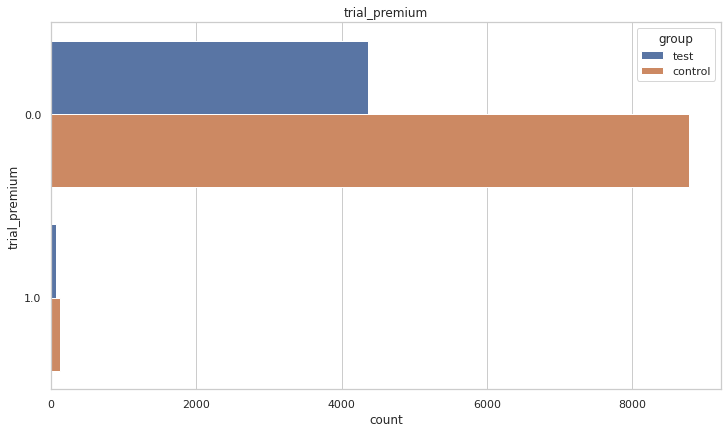

In [132]:
sns.countplot(data=transactions, y='trial_premium', hue='group').set(title='trial_premium');

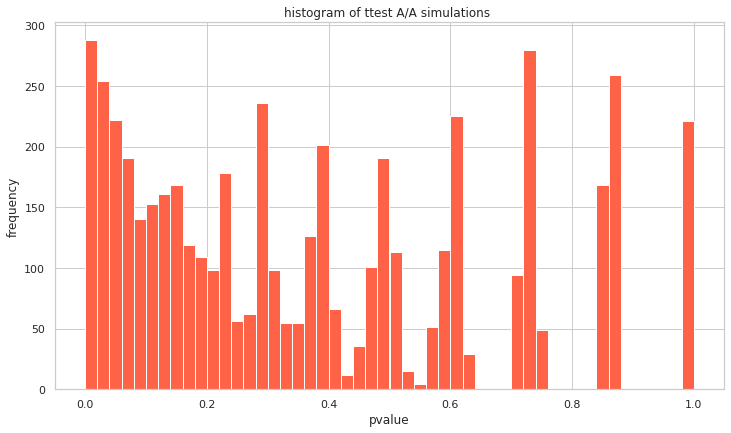

α=0.05, FPR=0.1264


In [133]:
# посчитаем стат значимость различий test и control у trial_premium
result = simulation(transactions[(transactions.revenue > 0) & (transactions.group == 'test')].trial_premium, \
                    transactions[(transactions.revenue > 0) & (transactions.group == 'control')].trial_premium)
graph(result)

H0 FPR<α

### Сравним premium_no_trial

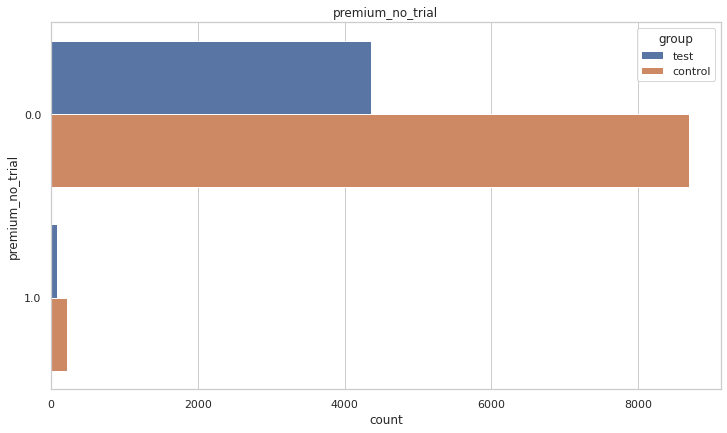

In [134]:
sns.countplot(data=transactions, y='premium_no_trial', hue='group').set(title='premium_no_trial');

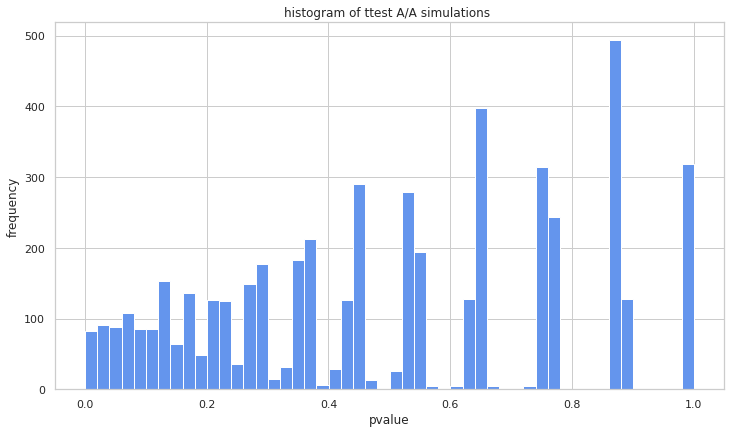

α=0.05, FPR=0.044


In [135]:
# посчитаем стат значимость различий test и control у premium_no_trial
result = simulation(transactions[(transactions.revenue > 0) & (transactions.group == 'test')].premium_no_trial, \
                    transactions[(transactions.revenue > 0) & (transactions.group == 'control')].premium_no_trial)
graph(result)

H0 FPR<α

In [136]:
# изменение в конверсии trial_premium и premium_no_trial
tppnt = transactions[transactions.revenue > 0].groupby('group') \
    .agg({'uid': 'count', 'trial_premium': 'sum', 'premium_no_trial': 'sum'}).reset_index()
tppnt['CR_trial_premium'] = round(tppnt.trial_premium / tppnt.uid, 4)
tppnt['CR_premium_no_trial'] = round(tppnt.premium_no_trial / tppnt.uid, 3)
tppnt = tppnt[['group', 'CR_trial_premium', 'CR_premium_no_trial']]
tppnt

,group,CR_trial_premium,CR_premium_no_trial
0,control,0.1775,0.315
1,test,0.2331,0.286


In [137]:
# объединим результаты
result = avg.merge(cr, on='group').merge(aru, on='group').merge(tppnt, on='group')
result = result.set_index('group').T.reset_index()
result['change_percent'] = round(result.test * 100 / result.control) - 100
ab_result = result.copy()
result

group,index,control,test,change_percent
0,avg_check,7362.380389,9696.295583,32.0
1,CR1,0.076000,0.060000,-21.0
2,ARPU,495.000000,527.000000,6.0
3,ARPPU,6512.000000,8768.000000,35.0
4,CR_trial_premium,0.177500,0.233100,31.0
5,CR_premium_no_trial,0.315000,0.286000,-9.0


### Результаты:

AvgCheck - H1(bootstrap)  
CR1 - H1(bootstrap)  
CR_trial_premium - H1(bootstrap)  
CR_premium_no_trial - H0(bootstrap)  

AvgCheck - увеличился на 32%  
CR1 - уменьшился на 21%  
ARPU - увеличился на 6%  
ARPPU - уменьшился на 9%  

### Вывод:

В результате тестирования признаков выявлены статистически значимые изменения во метриках: AvgCheck, CR1, CR_trial_premium.
Метрика CR_premium_no_trial статистически значимо не изменилась.

ARPU увеличился на 9%, а AvgCheck увеличился на 32%, в целом это хороший показатель. 

Подписку trial_premium стали брать чаще на 31%, а покупка premium_no_trial снизилась на 9%

Однако снижение CR1 на 21% тревожный звоночек.  
Такие показатели могут в длительной перспективе негативно сказаться на репутации продукта (уменьшая его привлекательность), размере аудитории и объёме выручки, об этом сигнализирует снижение ARPPU на 9%. 


<a id="4"></a>
## Сравнение тестовой и контрольной групп на изменения показателей метрик у покупателей trial_premium и premium_no_trial
[в оглавление](#0)  

Помимо общих результатов нам нужно увидеть как изменились показатели метрик у premium пользователей

In [138]:
# объединим таблицы users
users_control = pd.concat([users_control_1, users_control_2])
# переопределим группу
users_control['group'] = 'control'

In [139]:
# объединим все данные users в одну таблицу 
users = pd.concat([users_test, users_control])

In [140]:
# определим различающиеся страны в группах как 'Other'
uc_country = users_control.country.unique()
ut_country = users_test.country.unique()

# найдём общие страны
overall = list(set(uc_country).intersection(ut_country))
overall
# страны, которые есть только в uc_country
uc_only = list(set(uc_country).difference(ut_country))
# страны, которые есть только в ut_country
ut_only = list(set(ut_country).difference(uc_country))

In [141]:
# добавим колонок, которые понадобятся для сравнения

# переопределим страны которые присутствуют только в группе control или users как 'Other'
users['country_corr'] = users.country.apply(lambda x: x if x in overall else 'Other')
# декомпозируем колонку visit_days
users['visit_days_list'] = users.visit_days.apply(lambda x: [] if type(x) == float else x.split(','))
users['visit_days_count'] = users.visit_days_list.apply(lambda x: len(x))
# скорректируем данные для вычислений
users['attract_coeff'] = round(users.attraction_coeff / 100)
users['views'] = users.views_count.apply(lambda x: round(np.log(x), 1) if x>0 else 0) 

users.drop(columns=['country', 'total_revenue', 'attraction_coeff', 'views_count', 'visit_days'], inplace=True)
users.head(1)

,uid,age,coins,gender,age_filter_start,age_filter_end,was_premium,is_premium,group,country_corr,visit_days_list,visit_days_count,attract_coeff,views
0,892309896,27,0,1,24,30,0,0,test,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17]",14,7.0,4.5


In [142]:
# объединим все данные users в одну таблицу 
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2])
transactions.head(1)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium,test


In [143]:
# добавим колонок, которые понадобятся для сравнения
#transactions['joined_at'] = transactions.joined_at.astype('datetime64[ns]')
#transactions['joined'] = transactions['joined_at'].dt.strftime('%Y-%m')
transactions['trial_premium'] = transactions.product_type.apply(lambda x: 1 if x == 'trial_premium' else 0)
transactions['premium_no_trial'] = transactions.product_type.apply(lambda x: 1 if x == 'premium_no_trial' else 0)
#transactions.drop(columns=['country', 'group', 'joined_at', 'paid_at', 'payment_id'], inplace=True)
transactions['cr1'] = transactions.revenue.apply(lambda x: 1 if x>0 else 0)
transactions = transactions[['uid', 'revenue', 'trial_premium', 'premium_no_trial', 'cr1']]
transactions.head(1)

,uid,revenue,trial_premium,premium_no_trial,cr1
0,891345942,12909,1,0,1


In [144]:
# добавим данные users в  transactions
revenue_all_data = transactions.merge(users, on=['uid'], how='outer').fillna(0)
revenue_all_data.head(1)

,uid,revenue,trial_premium,premium_no_trial,cr1,age,coins,gender,age_filter_start,age_filter_end,was_premium,is_premium,group,country_corr,visit_days_list,visit_days_count,attract_coeff,views
0,891345942,12909.0,1.0,0.0,1.0,52,0,1,49,55,1,1,test,Italy,"[1, 2, 3, 4, 5, 6, 8, 10]",8,2.0,3.8


In [145]:
# отберём только интересующие нас данные trial_premium и premium_no_trial
transactions = revenue_all_data[(revenue_all_data.trial_premium == 1) | (revenue_all_data.premium_no_trial == 1)]
transactions.head(2)

,uid,revenue,trial_premium,premium_no_trial,cr1,age,coins,gender,age_filter_start,age_filter_end,was_premium,is_premium,group,country_corr,visit_days_list,visit_days_count,attract_coeff,views
0,891345942,12909.0,1.0,0.0,1.0,52,0,1,49,55,1,1,test,Italy,"[1, 2, 3, 4, 5, 6, 8, 10]",8,2.0,3.8
1,892054251,13923.0,1.0,0.0,1.0,37,0,1,34,40,1,1,test,United States of America,"[1, 2, 3, 4, 6, 7]",6,4.0,4.2


In [146]:
# всего пользователей
users_by_group = revenue_all_data.groupby('group').agg({'uid': 'nunique'}).reset_index()
users_by_group.columns = ['group', 'users']
users_by_group

,group,users
0,control,8604
1,test,4308


In [147]:
# всего покупателей
buyers_all = revenue_all_data[revenue_all_data.cr1 == 1].groupby('group').agg({'uid': 'nunique'}).reset_index()
buyers_all.columns = ['group', 'buyers']
buyers_all

,group,buyers
0,control,379
1,test,146


In [148]:
# вся прибыль по группам
revenue_all = revenue_all_data.groupby('group').agg({'revenue': 'sum'}).reset_index()
revenue_all.columns = ['group', 'revenue_all']
revenue_all

,group,revenue_all
0,control,4401995.0
1,test,2332226.0


In [149]:
# покупателей premium по группам
buyers_by_group = transactions[transactions.cr1 == 1].groupby('group').agg({'uid': 'nunique'}).reset_index()
buyers_by_group.columns = ['group', 'buyers_all_premium']
buyers_by_group

,group,buyers_all_premium
0,control,321
1,test,127


In [150]:
# посчитаем данные trial_premium и premium_no_trial по группам
trial_and_no = transactions.groupby(['uid', 'trial_premium', 'premium_no_trial', 'group']) \
    .agg({'country_corr': 'first', 'revenue': 'sum', 'cr1': 'count'}) \
    .rename(columns={'cr1': 'purchases'}).reset_index()
trial_and_no.head()

,uid,trial_premium,premium_no_trial,group,country_corr,revenue,purchases
0,891068079,0.0,1.0,control,Argentina,6292.0,1
1,891071157,0.0,1.0,test,United States of America,9100.0,1
2,891077727,0.0,1.0,control,Argentina,6292.0,1
3,891092322,0.0,1.0,control,Argentina,5278.0,1
4,891112263,0.0,1.0,control,United States of America,4680.0,1


In [151]:
# считаем ARPPU
t_and_no_by_gr = trial_and_no.groupby(['group', 'trial_premium', 'premium_no_trial']) \
    .agg({'uid': 'nunique', 'revenue': 'sum', 'purchases': 'sum'}).reset_index().drop(columns=['premium_no_trial'])
t_and_no_by_gr['ARPPU'] = round(t_and_no_by_gr['revenue'] / t_and_no_by_gr['uid'])
t_and_no_by_gr

,group,trial_premium,uid,revenue,purchases,ARPPU
0,control,0.0,201,1524068.0,213,7582.0
1,control,1.0,120,1416701.0,120,11806.0
2,test,0.0,67,810706.0,76,12100.0
3,test,1.0,61,800202.0,62,13118.0


In [152]:
# количество purchases
purchases = t_and_no_by_gr[['group', 'trial_premium', 'purchases']] \
    .pivot(index='group', columns='trial_premium', values='purchases').reset_index()
purchases.columns = ['group', 'purchases_premium_no_trial', 'purchases_trial_premium']
purchases

,group,purchases_premium_no_trial,purchases_trial_premium
0,control,213,120
1,test,76,62


In [153]:
# количество покупателей
uid = t_and_no_by_gr[['group', 'trial_premium', 'uid']] \
    .pivot(index='group', columns='trial_premium', values='uid').reset_index()
uid.columns = ['group', 'buyers_premium_no_trial', 'buyers_trial_premium']
uid

,group,buyers_premium_no_trial,buyers_trial_premium
0,control,201,120
1,test,67,61


In [154]:
# ARPPU по типам подписки
arppu = t_and_no_by_gr[['group', 'trial_premium', 'ARPPU']] \
    .pivot(index='group', columns='trial_premium', values='ARPPU').reset_index()
arppu.columns = ['group', 'arppu_premium_no_trial', 'arppu_trial_premium']
arppu

,group,arppu_premium_no_trial,arppu_trial_premium
0,control,7582.0,11806.0
1,test,12100.0,13118.0


In [155]:
# прибыль по группам, ARPU, ARPPU
revenue = t_and_no_by_gr[['group', 'trial_premium', 'revenue']] \
    .pivot(index='group', columns='trial_premium', values='revenue').reset_index()
revenue.columns = ['group', 'revenue_premium_no_trial', 'revenue_trial_premium']
revenue = revenue.merge(users_by_group, on='group').merge(buyers_by_group, on='group') \
    .merge(revenue_all, on='group').merge(buyers_all, on='group').merge(purchases, on='group')
revenue

,group,revenue_premium_no_trial,revenue_trial_premium,users,buyers_all_premium,revenue_all,buyers,purchases_premium_no_trial,purchases_trial_premium
0,control,1524068.0,1416701.0,8604,321,4401995.0,379,213,120
1,test,810706.0,800202.0,4308,127,2332226.0,146,76,62


In [156]:
# добавим метрики
revenue['revenue_all_premium'] = revenue['revenue_premium_no_trial'] + revenue['revenue_trial_premium']
revenue['ARPU'] = round((revenue['revenue_premium_no_trial'] + revenue['revenue_trial_premium']) / revenue['users'])
revenue['ARPPU'] = round((revenue['revenue_premium_no_trial'] + revenue['revenue_trial_premium']) / revenue['buyers_all_premium'])
revenue['share_revenue_premium_%'] = round((revenue['revenue_all_premium'] / revenue['revenue_all'])*100)
revenue['CR1_all_%'] = round(revenue['buyers'] / revenue['users'] * 100, 1)
revenue['CR1_premium_%'] = round(revenue['buyers_all_premium'] / revenue['users'] * 100, 1)
revenue['revenue_other'] = revenue['revenue_all'] - revenue['revenue_all_premium']
revenue['avg_check_premium_no_trial'] = round(revenue['revenue_premium_no_trial'] / revenue['purchases_premium_no_trial'])
revenue['avg_check_trial_premium'] = round(revenue['revenue_trial_premium'] / revenue['purchases_trial_premium'])
revenue

,group,revenue_premium_no_trial,revenue_trial_premium,users,buyers_all_premium,revenue_all,buyers,purchases_premium_no_trial,purchases_trial_premium,revenue_all_premium,ARPU,ARPPU,share_revenue_premium_%,CR1_all_%,CR1_premium_%,revenue_other,avg_check_premium_no_trial,avg_check_trial_premium
0,control,1524068.0,1416701.0,8604,321,4401995.0,379,213,120,2940769.0,342.0,9161.0,67.0,4.4,3.7,1461226.0,7155.0,11806.0
1,test,810706.0,800202.0,4308,127,2332226.0,146,76,62,1610908.0,374.0,12684.0,69.0,3.4,2.9,721318.0,10667.0,12906.0


In [157]:
# соберём всё вместе
all_data = revenue.merge(arppu, on='group').merge(uid, on='group').set_index('group')

# отбираем значения для метрик
all_data = all_data[['users', 'buyers', 'CR1_all_%', 'buyers_premium_no_trial', 'buyers_trial_premium',
    'buyers_all_premium', 'CR1_premium_%', 'revenue_premium_no_trial', 'revenue_trial_premium',
    'revenue_all_premium', 'revenue_other', 'revenue_all', 'share_revenue_premium_%', 'ARPU',
    'arppu_premium_no_trial', 'arppu_trial_premium', 'ARPPU', 'avg_check_premium_no_trial',
    'avg_check_trial_premium']]

# расчёт доли
absolute = all_data.users.test / all_data.users.control

# преобразуем форму таблицы
all_data = all_data.T.reset_index()
all_data.columns = ['metric', 'control', 'test']

# выбираем метрики с абсолютными показателями
metrics = ['users', 'buyers', 'buyers_premium_no_trial', 'buyers_trial_premium', 'buyers_all_premium',
        'revenue_premium_no_trial', 'revenue_trial_premium', 'revenue_all_premium', 'revenue_other',
        'revenue_all']


# считаем показатель изменения метрик в %
all_data['change_%'] = all_data.apply(lambda x: 
                                      # считаем абсолютные показатели
                                      round(x['test'] / x['control'] / absolute * 100 - 100)
                                      if x.metric in metrics else 
                                      # считаем относительные показатели
                                      round(x['test'] * 100 / x['control'] - 100),
                                      axis=1)

all_data.index = all_data.metric.values
all_data = all_data.drop(columns='metric')
premium_result = all_data.copy()

In [158]:
# показатели 
all_data

,control,test,change_%
users,8604.0,4308.0,0
buyers,379.0,146.0,-23
CR1_all_%,4.4,3.4,-23
buyers_premium_no_trial,201.0,67.0,-33
buyers_trial_premium,120.0,61.0,2
buyers_all_premium,321.0,127.0,-21
CR1_premium_%,3.7,2.9,-22
revenue_premium_no_trial,1524068.0,810706.0,6
revenue_trial_premium,1416701.0,800202.0,13
revenue_all_premium,2940769.0,1610908.0,9


### Вывод:
Мы провели сравнение тестовой и контрольной групп на изменения показателей метрик у покупателей trial_premium и premium_no_trial

Негативные показатели:  
- Количество покупателей в тестовой группе снизилось на 23%  
- Общая конверсия в покупку снизилась на 23%, с 4,4 до 3,4 процентов от количества пользователей.  
- Количество покупателей по premium_no_trial снизилось на 33%, а trial_premium не изменилось, в целом premium покупок уменьшилось на 22%  

Позитивные показатели:  
- Прибыль увеличилась premium_no_trial на 6%, trial_premium на 13%, общая прибыль на 6% (только за счёт изменений в premium, прибыль от других продаж не изменилась). Доля premium в прибыли увеличилась на 9%  
- Прибыль с пользователя ARPU увеличилось на 9%  
- Больше всего изменился показатель количества прибыли с покупателя ARPPU c premium_no_trial увеличившись на 60%  
- ARPPU по trial_premium увеличился на 11%  
- Общий ARPPU увеличился на 38%  
- Средний чек premium_no_trial  в тестовой группе увеличился на 49%

<a id="5"></a>

## Измерение изменений размера выручки в зависимости от показателей признака у premium пользователей
[в оглавление](#0) 

Проверим как изменилась выручка в зависимости от показателей признака пользователей

In [159]:
# считаем метрики
def count_metrics(revenue_all_data, transactions):
    try:
        # всего пользователей
        users_by_group = revenue_all_data.groupby('group').agg({'uid': 'nunique'}).reset_index()
        users_by_group.columns = ['group', 'users']
        # всего покупателей
        buyers_all = revenue_all_data[revenue_all_data.cr1 == 1].groupby('group').agg({'uid': 'nunique'}).reset_index()
        buyers_all.columns = ['group', 'buyers']
        # вся прибыль по группам
        revenue_all = revenue_all_data.groupby('group').agg({'revenue': 'sum'}).reset_index()
        revenue_all.columns = ['group', 'revenue_all']
        # покупателей premium по группам
        buyers_by_group = transactions[transactions.cr1 == 1].groupby('group').agg({'uid': 'nunique'}).reset_index()
        buyers_by_group.columns = ['group', 'buyers_all_premium']
        # посчитаем данные trial_premium и premium_no_trial по группам
        trial_and_no = transactions.groupby(['uid', 'trial_premium', 'premium_no_trial', 'group']) \
            .agg({'country_corr': 'first', 'revenue': 'sum', 'cr1': 'count'}) \
            .rename(columns={'cr1': 'purchases'}).reset_index()
        # считаем ARPPU
        t_and_no_by_gr = trial_and_no.groupby(['group', 'trial_premium', 'premium_no_trial']) \
            .agg({'uid': 'nunique', 'revenue': 'sum', 'purchases': 'sum'}).reset_index().drop(columns=['premium_no_trial'])
        t_and_no_by_gr['ARPPU'] = round(t_and_no_by_gr['revenue'] / t_and_no_by_gr['uid'])
        # количество purchases
        purchases = t_and_no_by_gr[['group', 'trial_premium', 'purchases']] \
            .pivot(index='group', columns='trial_premium', values='purchases').reset_index()
        purchases.columns = ['group', 'purchases_premium_no_trial', 'purchases_trial_premium']
        # количество покупателей
        uid = t_and_no_by_gr[['group', 'trial_premium', 'uid']] \
            .pivot(index='group', columns='trial_premium', values='uid').reset_index()
        uid.columns = ['group', 'buyers_premium_no_trial', 'buyers_trial_premium']
        # ARPPU по типам подписки
        arppu = t_and_no_by_gr[['group', 'trial_premium', 'ARPPU']] \
            .pivot(index='group', columns='trial_premium', values='ARPPU').reset_index()
        arppu.columns = ['group', 'arppu_premium_no_trial', 'arppu_trial_premium']
        # прибыль по группам, ARPU, ARPPU
        revenue = t_and_no_by_gr[['group', 'trial_premium', 'revenue']] \
            .pivot(index='group', columns='trial_premium', values='revenue').reset_index()
        revenue.columns = ['group', 'revenue_premium_no_trial', 'revenue_trial_premium']
        revenue = revenue.merge(users_by_group, on='group').merge(buyers_by_group, on='group') \
            .merge(revenue_all, on='group').merge(buyers_all, on='group').merge(purchases, on='group')
        # добавим метрики
        revenue['revenue_all_premium'] = revenue['revenue_premium_no_trial'] + revenue['revenue_trial_premium']
        revenue['ARPU'] = round((revenue['revenue_premium_no_trial'] + revenue['revenue_trial_premium']) / revenue['users'])
        revenue['ARPPU'] = round((revenue['revenue_premium_no_trial'] + revenue['revenue_trial_premium']) / revenue['buyers_all_premium'])
        revenue['share_revenue_premium_%'] = round((revenue['revenue_all_premium'] / revenue['revenue_all'])*100)
        revenue['CR1_all_%'] = round(revenue['buyers'] / revenue['users'] * 100, 1)
        revenue['CR1_premium_%'] = round(revenue['buyers_all_premium'] / revenue['users'] * 100, 1)
        revenue['revenue_other'] = revenue['revenue_all'] - revenue['revenue_all_premium']
        revenue['avg_check_premium_no_trial'] = round(revenue['revenue_premium_no_trial'] / revenue['purchases_premium_no_trial'])
        revenue['avg_check_trial_premium'] = round(revenue['revenue_trial_premium'] / revenue['purchases_trial_premium'])
        # соберём всё вместе
        all_data = revenue.merge(arppu, on='group').merge(uid, on='group').set_index('group')
        # отбираем значения для метрик
        all_data = all_data[['users', 'buyers', 'CR1_all_%', 'buyers_premium_no_trial', 'buyers_trial_premium',
            'buyers_all_premium', 'CR1_premium_%', 'revenue_premium_no_trial', 'revenue_trial_premium',
            'revenue_all_premium', 'revenue_other', 'revenue_all', 'share_revenue_premium_%', 'ARPU',
            'arppu_premium_no_trial', 'arppu_trial_premium', 'ARPPU', 'avg_check_premium_no_trial',
            'avg_check_trial_premium']]
        # расчёт доли
        absolute = all_data.users.test / all_data.users.control
        # преобразуем форму таблицы
        all_data = all_data.T.reset_index()
        all_data.columns = ['metric', 'control', 'test']
        # выбираем метрики с абсолютными показателями
        metrics = ['users', 'buyers', 'buyers_premium_no_trial', 'buyers_trial_premium', 'buyers_all_premium',
                'revenue_premium_no_trial', 'revenue_trial_premium', 'revenue_all_premium', 'revenue_other',
                'revenue_all']
        # считаем показатель изменения метрик в %
        all_data['change_%'] = all_data.apply(lambda x: 
                                              # считаем абсолютные показатели
                                              round(x['test'] / x['control'] / absolute * 100 - 100)
                                              if x.metric in metrics else 
                                              # считаем относительные показатели
                                              round(x['test'] * 100 / x['control'] - 100),
                                              axis=1)
        all_data.index = all_data.metric.values
        all_data = all_data.drop(columns='metric')
        return all_data
    except:
        pass
        

In [160]:
# получить результаты в разрезе коэффециента 
def get_statistic(values, column, revenue_all_data=revenue_all_data):
    result = []
    for value in values:
        # получим данные по значению определённого признака
        data = revenue_all_data[revenue_all_data[column] == value]
        # получаем только покупки по промо
        transactions = data[(data.trial_premium == 1) | (data.premium_no_trial == 1)]
        try:
            all_data = count_metrics(data, transactions)
            all_data = all_data[['change_%']]
            all_data.columns = [value]
            result.append(all_data)
        except:
            pass
    return pd.concat(result, axis=1).T.reset_index().rename(columns={'index': 'indexes'})


,indexes,users,buyers,CR1_all_%,buyers_premium_no_trial,buyers_trial_premium,buyers_all_premium,CR1_premium_%,revenue_premium_no_trial,revenue_trial_premium,revenue_all_premium,revenue_other,revenue_all,share_revenue_premium_%,ARPU,arppu_premium_no_trial,arppu_trial_premium,ARPPU,avg_check_premium_no_trial,avg_check_trial_premium
5,Italy,0,-47,-46,-20,-35,-22,-22,-26,-41,-29,-82,-66,113,-29,-7,-9,-9,-10,-9
8,United Kingdom (Great Britain),0,-31,-31,-34,-31,-33,-34,-39,-22,-32,-78,-55,51,-32,-8,13,1,14,13
7,Belgium,0,-39,-39,-64,-8,-34,-35,-24,-22,-22,74,-13,-11,-22,112,-15,17,112,-15
2,Israel,0,-56,-56,-71,32,-45,-45,-39,49,-2,-24,-9,7,-2,109,12,77,109,12
10,Canada,0,-10,-10,17,-35,-11,-12,96,-31,4,-6,1,3,4,67,6,17,25,6
0,United States of America,0,-14,-14,-37,0,-20,-19,-21,11,-4,52,11,-14,-3,25,11,20,20,11
6,Argentina,0,-37,-36,-17,-78,-43,-44,22,-72,-30,189,41,-50,-30,47,26,24,47,26
3,France,0,-34,-35,-58,70,-20,-21,-26,98,44,246,87,-23,44,78,16,79,24,16
1,Germany,0,31,27,-47,273,24,26,-53,238,68,141,88,-10,68,-11,-9,35,-11,-9
9,United Arab Emirates,0,39,38,59,39,51,54,164,57,133,-40,105,13,133,66,13,54,43,13


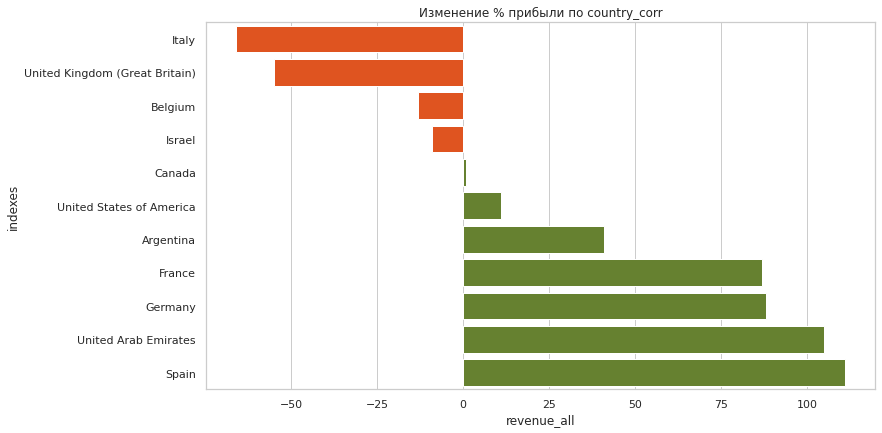

In [161]:
# список уникальных значений поиска
values = users.country_corr.unique()

# колонка сравнительных данных
column = 'country_corr'

# получить данные
result = get_statistic(values, column).sort_values('revenue_all')
display(result)

# отображение результата
title = 'Изменение % прибыли по ' + column
palette = ['orangered' if (x<0) else 'olivedrab' for x in result['revenue_all']]
sns.barplot(data=result, x='revenue_all', y='indexes', palette=palette).set(title=title);

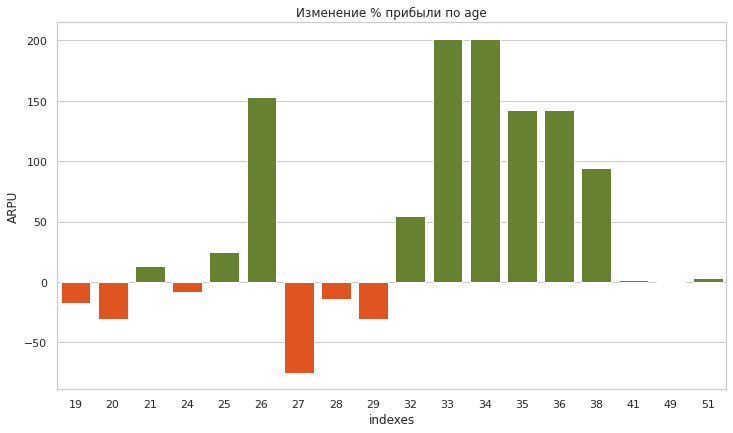

In [162]:
# список уникальных значений поиска
values = users.age.unique().tolist()

# колонка сравнительных данных
column = 'age'

# получить данные
result = get_statistic(values, column).sort_values('indexes').reset_index().drop(columns='index')
#display(result)

# отображение результата
title = 'Изменение % прибыли по ' + column
palette = ['orangered' if (x<0) else 'olivedrab' for x in result['ARPU']]
sns.barplot(data=result, y='ARPU', x='indexes', palette=palette).set(title=title);

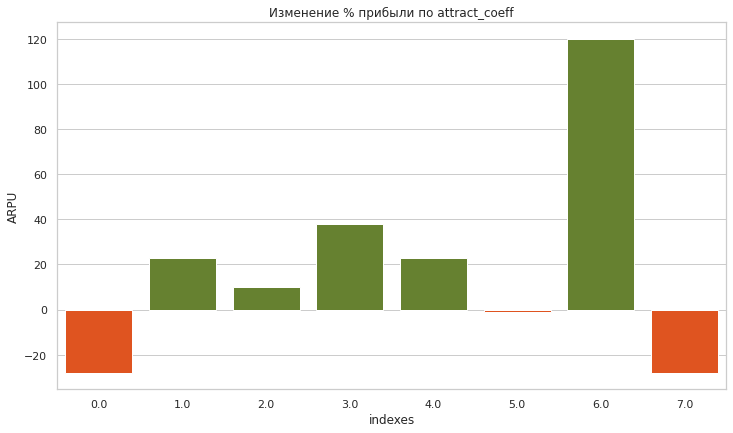

In [163]:
# список уникальных значений поиска
values = users.attract_coeff.unique().tolist()
# колонка сравнительных данных
column = 'attract_coeff'

# получить данные
result = get_statistic(values, column).sort_values('indexes').reset_index().drop(columns='index')
#display(result)

# отображение результата
title = 'Изменение % прибыли по ' + column
palette = ['orangered' if (x<0) else 'olivedrab' for x in result['ARPU']]
sns.barplot(data=result, y='ARPU', x='indexes', palette=palette).set(title=title);

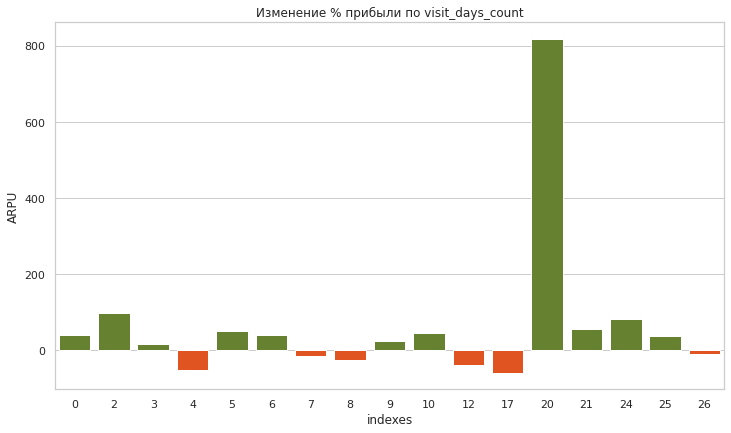

In [164]:
# список уникальных значений поиска
values = users.visit_days_count.unique().tolist()

# колонка сравнительных данных
column = 'visit_days_count'

# получить данные
result = get_statistic(values, column).sort_values('indexes').reset_index().drop(columns='index')
#display(result)

# отображение результата
title = 'Изменение % прибыли по ' + column
palette = ['orangered' if (x<0) else 'olivedrab' for x in result['ARPU']]
sns.barplot(data=result, y='ARPU', x='indexes', palette=palette).set(title=title);

## Вывод:
Мы рассматриваем в качестве основной метрики для изучения - показатель прибыли (revenue) на пользователей использующих премиум-подписки в разрезах проксиметрик.

Есть страны результат которых показал как положительные результаты так и отрицательные показатели изменения прибыли.  

положительные:
Spain +111%  
United Arab Emirates +105%  
Germany +88%  
France +87%  
Argentina +41%  
United States of America +11%

отрицательные:   
Italy -66%  
United Kingdom (Great Britain) -55%
Belgium -13%
Israel -9

Возрастные различия: 26, 32-38 лет платят чаще чем остальные возрастные группы.

По коэффециенту привлекательности прирост увеличился на оценках 200-600, причем в диапазоне 600-700 стали платиьб на 120% чаще.

Любопытная волнообразная динамика покупки в зависимости от дня посещения после регистрации.  
На 20 день стали платить +800% чаще, вероятно в этот день демонстрируется pop-up рекламное предложение на выгодную цену подписки.

<a id="6"></a>

## Retention rate у premium пользователей
[в оглавление](#0) 

In [165]:
# объединим все данные users в одну таблицу 
trans = pd.concat([transactions_test, transactions_control_1, transactions_control_2])
trans = trans[['uid', 'paid_at', 'product_type', 'revenue', 'group']]
trans.head()

,uid,paid_at,product_type,revenue,group
0,891345942,2017-11-13 15:04:00,trial_premium,12909,test
1,892054251,2017-10-30 01:37:00,trial_premium,13923,test
2,892236423,2017-10-23 00:15:00,other_type,3783,test
3,892236423,2017-10-27 22:38:00,other_type,3783,test
4,892168170,2017-10-27 19:10:00,trial_premium,9087,test


In [166]:
# добавим колонку
trans['month'] = trans.paid_at.dt.strftime('%m').astype('int32')

#отберём необходимые
select = ['trial_premium', 'premium_no_trial']
trans = trans[trans.product_type.isin(select)]
trans

,uid,paid_at,product_type,revenue,group,month
0,891345942,2017-11-13 15:04:00,trial_premium,12909,test,11
1,892054251,2017-10-30 01:37:00,trial_premium,13923,test,10
4,892168170,2017-10-27 19:10:00,trial_premium,9087,test,10
5,892426491,2017-10-15 22:39:00,premium_no_trial,12597,test,10
6,891558921,2017-10-11 09:05:00,premium_no_trial,9100,test,10
...,...,...,...,...,...,...
322,891435993,2017-03-11 21:26:00,premium_no_trial,3549,control,3
323,891985866,2017-10-30 15:35:00,trial_premium,16640,control,10
324,891491145,2017-09-11 20:32:00,trial_premium,12727,control,9
326,891668253,2017-11-15 00:57:00,trial_premium,9997,control,11


In [167]:
# список uid которые платили по несколько раз в месяц за месячную подписку
error = trans.groupby(['month', 'uid']).agg({'revenue': 'count'}).reset_index()
error_uid = error[error.revenue >1].uid.tolist()
trans[trans.uid.isin(error_uid)].sort_values(['month', 'uid'])

,uid,paid_at,product_type,revenue,group,month
279,891637005,2017-02-11 13:39:00,premium_no_trial,6396,control,2
292,891637005,2017-02-11 13:38:00,premium_no_trial,6292,control,2
138,891216033,2017-07-11 12:47:00,premium_no_trial,6292,control,7
269,891216033,2017-07-11 12:47:00,premium_no_trial,6292,control,7
90,891219540,2017-07-11 10:58:00,premium_no_trial,4719,control,7
144,891219540,2017-07-11 10:58:00,premium_no_trial,4719,control,7
152,891725043,2017-10-29 07:48:00,premium_no_trial,9217,test,10
220,891725043,2017-10-29 07:48:00,premium_no_trial,9217,test,10
11,891861048,2017-10-11 19:00:00,premium_no_trial,3588,test,10
234,891861048,2017-10-26 03:00:00,premium_no_trial,3588,test,10


In [168]:
trans.paid_at.min(), trans.paid_at.max()

(Timestamp('2017-01-11 02:56:00'), Timestamp('2017-12-11 23:28:00'))

In [169]:
# определяем когорты для uid
cohort = trans.groupby('uid').agg({'month': 'min'}).reset_index().rename(columns={'month': 'cohort'})
cohort.head()

,uid,cohort
0,891068079,12
1,891071157,10
2,891077727,10
3,891092322,10
4,891112263,11


In [170]:
# определяем размеры когорт
size_cohort = cohort.groupby('cohort').agg({'uid': 'count'}).reset_index().rename(columns={'uid': 'size_cohort'})
size_cohort.head()

,cohort,size_cohort
0,1,7
1,2,17
2,3,13
3,4,19
4,5,30


In [171]:
# определяем месяца удержания для каждого uid
group = trans.groupby(['uid', 'month']).agg({'product_type': 'first'}).reset_index().drop(columns=['product_type'])
# присваиваем когорту для каждого платежа
group = group.merge(cohort, on='uid', how='left')
group['month'] = group.month - group.cohort
group.head()

,uid,month,cohort
0,891068079,0,12
1,891071157,0,10
2,891077727,0,10
3,891092322,0,10
4,891112263,0,11


In [172]:
# собираем когорты
result = group.groupby(['cohort', 'month']).agg({'uid': 'count'}).reset_index().rename(columns={'uid': 'users'})
result = result.merge(size_cohort, on='cohort', how='left')
result['RR'] = round(result.users / result.size_cohort, 2)
result#.head()

,cohort,month,users,size_cohort,RR
0,1,0,7,7,1.00
1,2,0,17,17,1.00
2,3,0,13,13,1.00
3,4,0,19,19,1.00
4,5,0,30,30,1.00
5,6,0,29,29,1.00
6,6,4,1,29,0.03
7,7,0,17,17,1.00
8,7,3,1,17,0.06
9,8,0,17,17,1.00


In [173]:
# построение графика когорт
def get_cohort_chart(data, index, columns, values, title, fmt):
    chart = data.pivot_table(index=index, columns=columns, values=values, aggfunc='mean') 
    plt.figure(figsize=(12, 6.75))
    plt.title(title)
    sns.heatmap(chart, annot=True, fmt=fmt, cmap='Blues');

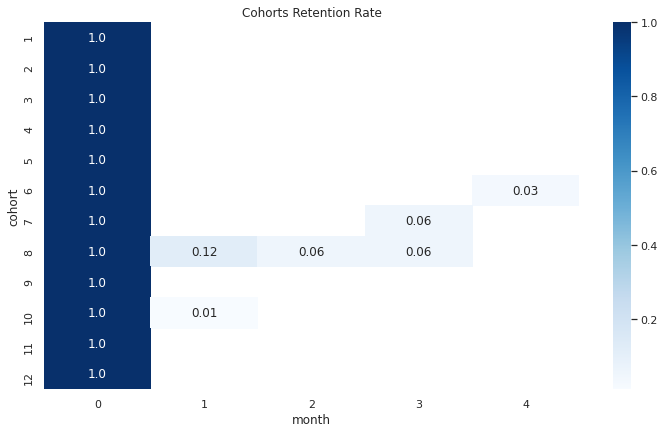

In [174]:
# построим RR
get_cohort_chart(result, 'cohort', 'month', 'RR', 'Cohorts Retention Rate', '')

### Вывод:
Удержание подписки premium низкое.  
Только 8 месяц показал удержание, 2 человека продлили на следующий месяц, 1 человек подписывался 4 месяца подряд.  
Данных анализа изменений уровня оттока по подписке - не достаточно.

<a id="7"></a>

## Измерение доли trial_premium в test и control группах
[в оглавление](#0) 

Посмотрим как изменилась доля trial_premium относительно premium_no_trial

In [175]:
trial_premium = trans[trans.product_type == 'trial_premium']
premium_no_trial = trans[trans.product_type == 'premium_no_trial']

In [176]:
# сгруппируем пользователей
tp = trial_premium.groupby(['group', 'month']).agg({'uid': 'count'}) \
    .reset_index().rename(columns={'uid': 'users_trial'})
tp.head()

,group,month,users_trial
0,control,1,3
1,control,2,4
2,control,3,1
3,control,5,10
4,control,6,8


In [177]:
pnt = premium_no_trial.groupby(['group', 'month']).agg({'uid': 'count'}) \
    .reset_index().rename(columns={'uid': 'users_no_trial'})
pnt.head()

,group,month,users_no_trial
0,control,1,3
1,control,2,8
2,control,3,7
3,control,4,12
4,control,5,14


In [178]:
# объединим
tppnt = tp.merge(pnt, on=['group', 'month'], how='outer').fillna(0) \
    .set_index(['group', 'month']).unstack(level=0)
tppnt.columns = ['t_control', 't_test', 'nt_control', 'nt_test']
tppnt['all_users'] = tppnt.sum(axis=1)
tppnt['all_test'] = tppnt.nt_test + tppnt.t_test
tppnt['mean_control'] = (tppnt.t_control + tppnt.nt_control) / absolute
tppnt['trial_users'] = tppnt.t_control + tppnt.t_test
tppnt['no_trial_users'] = tppnt.nt_control + tppnt.nt_test
# доля trial из всех в control
tppnt['share_trial_control'] =  round(tppnt.t_control / absolute / tppnt.mean_control, 2)
# доля trial из всех в test   
tppnt['share_trial_test'] =  round(tppnt.t_test / tppnt.all_test, 2)
tppnt['test/control'] = tppnt.share_trial_test / tppnt.share_trial_control
tppnt.replace(np.inf, 0, inplace=True)
tppnt

,t_control,t_test,nt_control,nt_test,all_users,all_test,mean_control,trial_users,no_trial_users,share_trial_control,share_trial_test,test/control
month,,,,,,,,,,,,
1,3.0,1.0,3.0,0.0,7.0,1.0,11.983287,4.0,3.0,0.50,1.00,2.000000
2,4.0,3.0,8.0,3.0,18.0,6.0,23.966574,7.0,11.0,0.33,0.50,1.515152
3,1.0,3.0,7.0,2.0,13.0,5.0,15.977716,4.0,9.0,0.12,0.60,5.000000
4,0.0,2.0,12.0,5.0,19.0,7.0,23.966574,2.0,17.0,0.00,0.29,0.000000
5,10.0,1.0,14.0,5.0,30.0,6.0,47.933148,11.0,19.0,0.42,0.17,0.404762
6,8.0,2.0,17.0,2.0,29.0,4.0,49.930362,10.0,19.0,0.32,0.50,1.562500
7,4.0,2.0,11.0,2.0,19.0,4.0,29.958217,6.0,13.0,0.27,0.50,1.851852
8,6.0,1.0,9.0,1.0,17.0,2.0,29.958217,7.0,10.0,0.40,0.50,1.250000
9,6.0,1.0,5.0,2.0,14.0,3.0,21.969359,7.0,7.0,0.55,0.33,0.600000


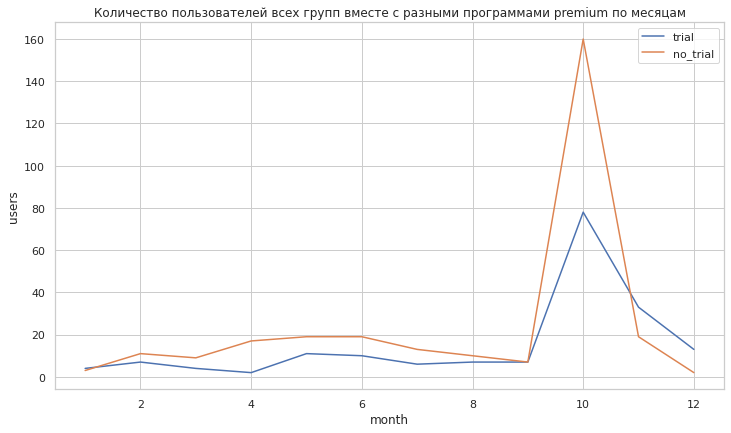

In [179]:
sns.lineplot(data=tppnt, x='month', y='trial_users')
sns.lineplot(data=tppnt, x='month', y='no_trial_users')
#sns.lineplot(data=tppnt, x='month', y='all_users')
plt.ylabel('users')
plt.title('Количество пользователей всех групп вместе с разными программами premium по месяцам')
#plt.legend(['trial', 'no_trial', 'all']);
plt.legend(['trial', 'no_trial']);

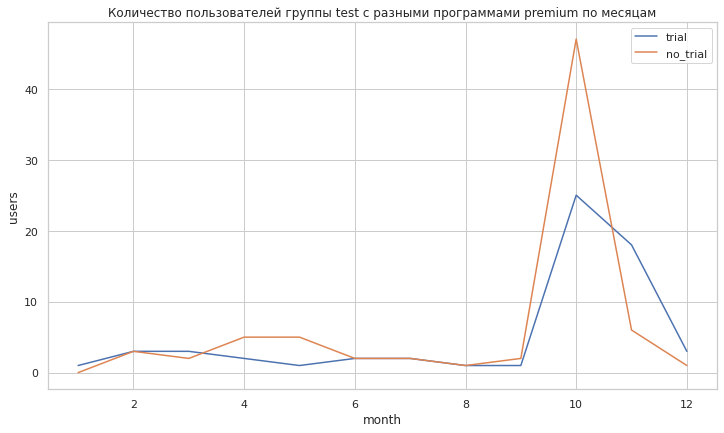

In [180]:
sns.lineplot(data=tppnt, x='month', y='t_test')
sns.lineplot(data=tppnt, x='month', y='nt_test')
#sns.lineplot(data=tppnt, x='month', y='all_test')
plt.ylabel('users')
plt.title('Количество пользователей группы test с разными программами premium по месяцам')
#plt.legend(['trial', 'no_trial', 'all']);
plt.legend(['trial', 'no_trial']);

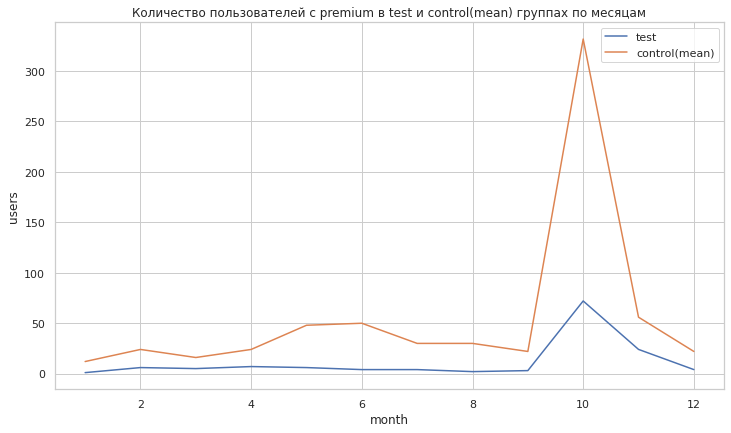

In [181]:
sns.lineplot(data=tppnt, x='month', y='all_test')
sns.lineplot(data=tppnt, x='month', y='mean_control')
plt.ylabel('users')
plt.title('Количество пользователей с premium в test и control(mean) группах по месяцам')
plt.legend(['test', 'control(mean)']);

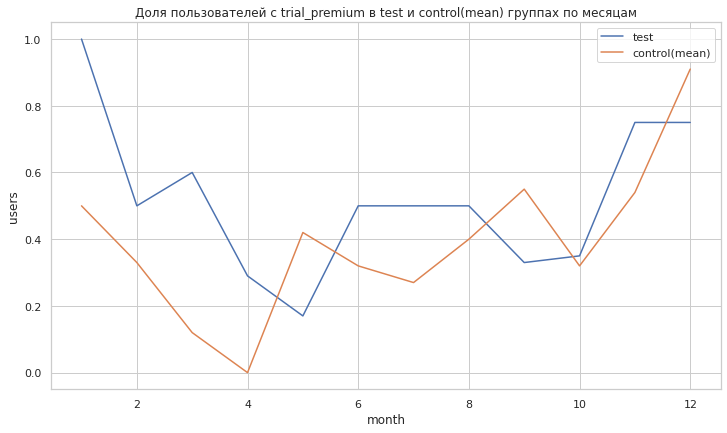

In [182]:
sns.lineplot(data=tppnt, x='month', y='share_trial_test')
sns.lineplot(data=tppnt, x='month', y='share_trial_control')
plt.ylabel('users')
plt.title('Доля пользователей с trial_premium в test и control(mean) группах по месяцам')
plt.legend(['test', 'control(mean)']);

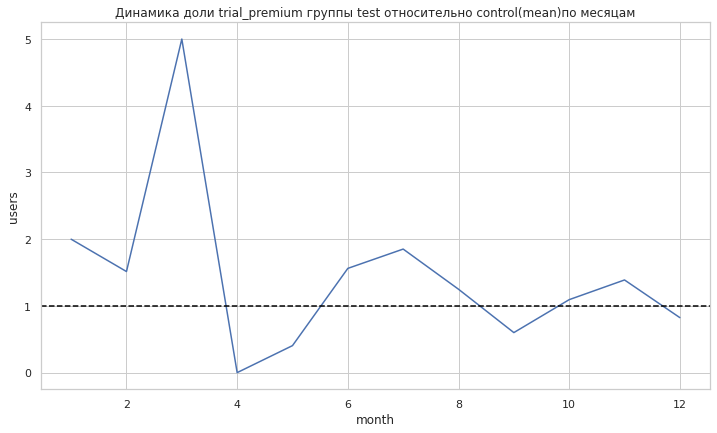

In [183]:
sns.lineplot(data=tppnt, x='month', y='test/control')
plt.ylabel('users')
plt.title('Динамика доли trial_premium группы test относительно control(mean)по месяцам')
plt.axhline(y=1, color='black', linestyle='--');

In [184]:
# доля test относительно доли control(mean), в доле trial_premium относительно всех premium
round(tppnt['test/control'].mean(), 2)

1.46

### Вывод:
Мы сравнивали средние значения control групп относительно группы test по месяцам.  
Выделили доли trial_premium и premium_no_trial для каждой из групп.  
Сравнили отношение долей у control и test групп по trial_premium.

Выяснили что в среднем за время эксперимента доля подписок на trial_premium у группы test была больше в 1.46 раза чем у группы control в относительном значении всех подписок на premium.

In [185]:
# показатели метрик результатов A/B теста
ab_result

group,index,control,test,change_percent
0,avg_check,7362.380389,9696.295583,32.0
1,CR1,0.076000,0.060000,-21.0
2,ARPU,495.000000,527.000000,6.0
3,ARPPU,6512.000000,8768.000000,35.0
4,CR_trial_premium,0.177500,0.233100,31.0
5,CR_premium_no_trial,0.315000,0.286000,-9.0


In [186]:
# показатели метрик результатов A/B теста покупателей trial_premium и premium_no_trial
premium_result

,control,test,change_%
users,8604.0,4308.0,0
buyers,379.0,146.0,-23
CR1_all_%,4.4,3.4,-23
buyers_premium_no_trial,201.0,67.0,-33
buyers_trial_premium,120.0,61.0,2
buyers_all_premium,321.0,127.0,-21
CR1_premium_%,3.7,2.9,-22
revenue_premium_no_trial,1524068.0,810706.0,6
revenue_trial_premium,1416701.0,800202.0,13
revenue_all_premium,2940769.0,1610908.0,9


<a id="8"></a>

# Заключение:
[в оглавление](#0) 

Эксперимент в целом можно считать успешным.  

Выяснили что в среднем за время эксперимента доля подписок на trial_premium у группы test была больше в 1.46 раза чем у группы control в относительном значении всех подписок на premium.

Система сплитирования сработала удовлетворительно (без учёта выбросов), есть некритичные ошибки в данных.  

Показатели retention говорят о низкой вовлечённости пользователей в программу premium, это скорее разовая подписка чем ежемесячная.

Нововведение имеет смысл вводить с учётом показателей чувствительных метрик:
- страна
- пол
- возраст
- коэффециент привлекательности
- день с момента регистрации

Сформулировать систему динамического ценообразования на основании проксиметрик.

### Дополнительно:
Однако стоит обратить внимание на сравнение показателей результатов A/B теста всех пользователей и покупателей trial premium:

CR1 -21%  
CR1_premium -23%  

ARPU +6%  
ARPU_premium +9%  

При увеличении прибыли на 6% у всех пользователей а также на 9% у премиум, конверсия снизилась на 21% у всех пользователей и на 23% у премиум.
Такие показатели могут в долгосрочной перспективе негативно сказаться на репутации продукта (уменьшая его привлекательность), размере аудитории и объёме выручки.